# Deep learning basics - components of artificial neural nets

## Order of things

1. A few components
2. Regularization
3. Recurrent component + dropout

## Things in this notebook

- Dense layer
- CNNs
- RNN, GRU, LSTM
- batch norm
- drop out
- telemetry of activations and weights

In [2]:
%matplotlib inline

In [3]:
from fastai.basics import torch

from typing import Union, List
import pathlib
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [4]:
path = pathlib.Path("../data/mandelbrot_fraktal.png")

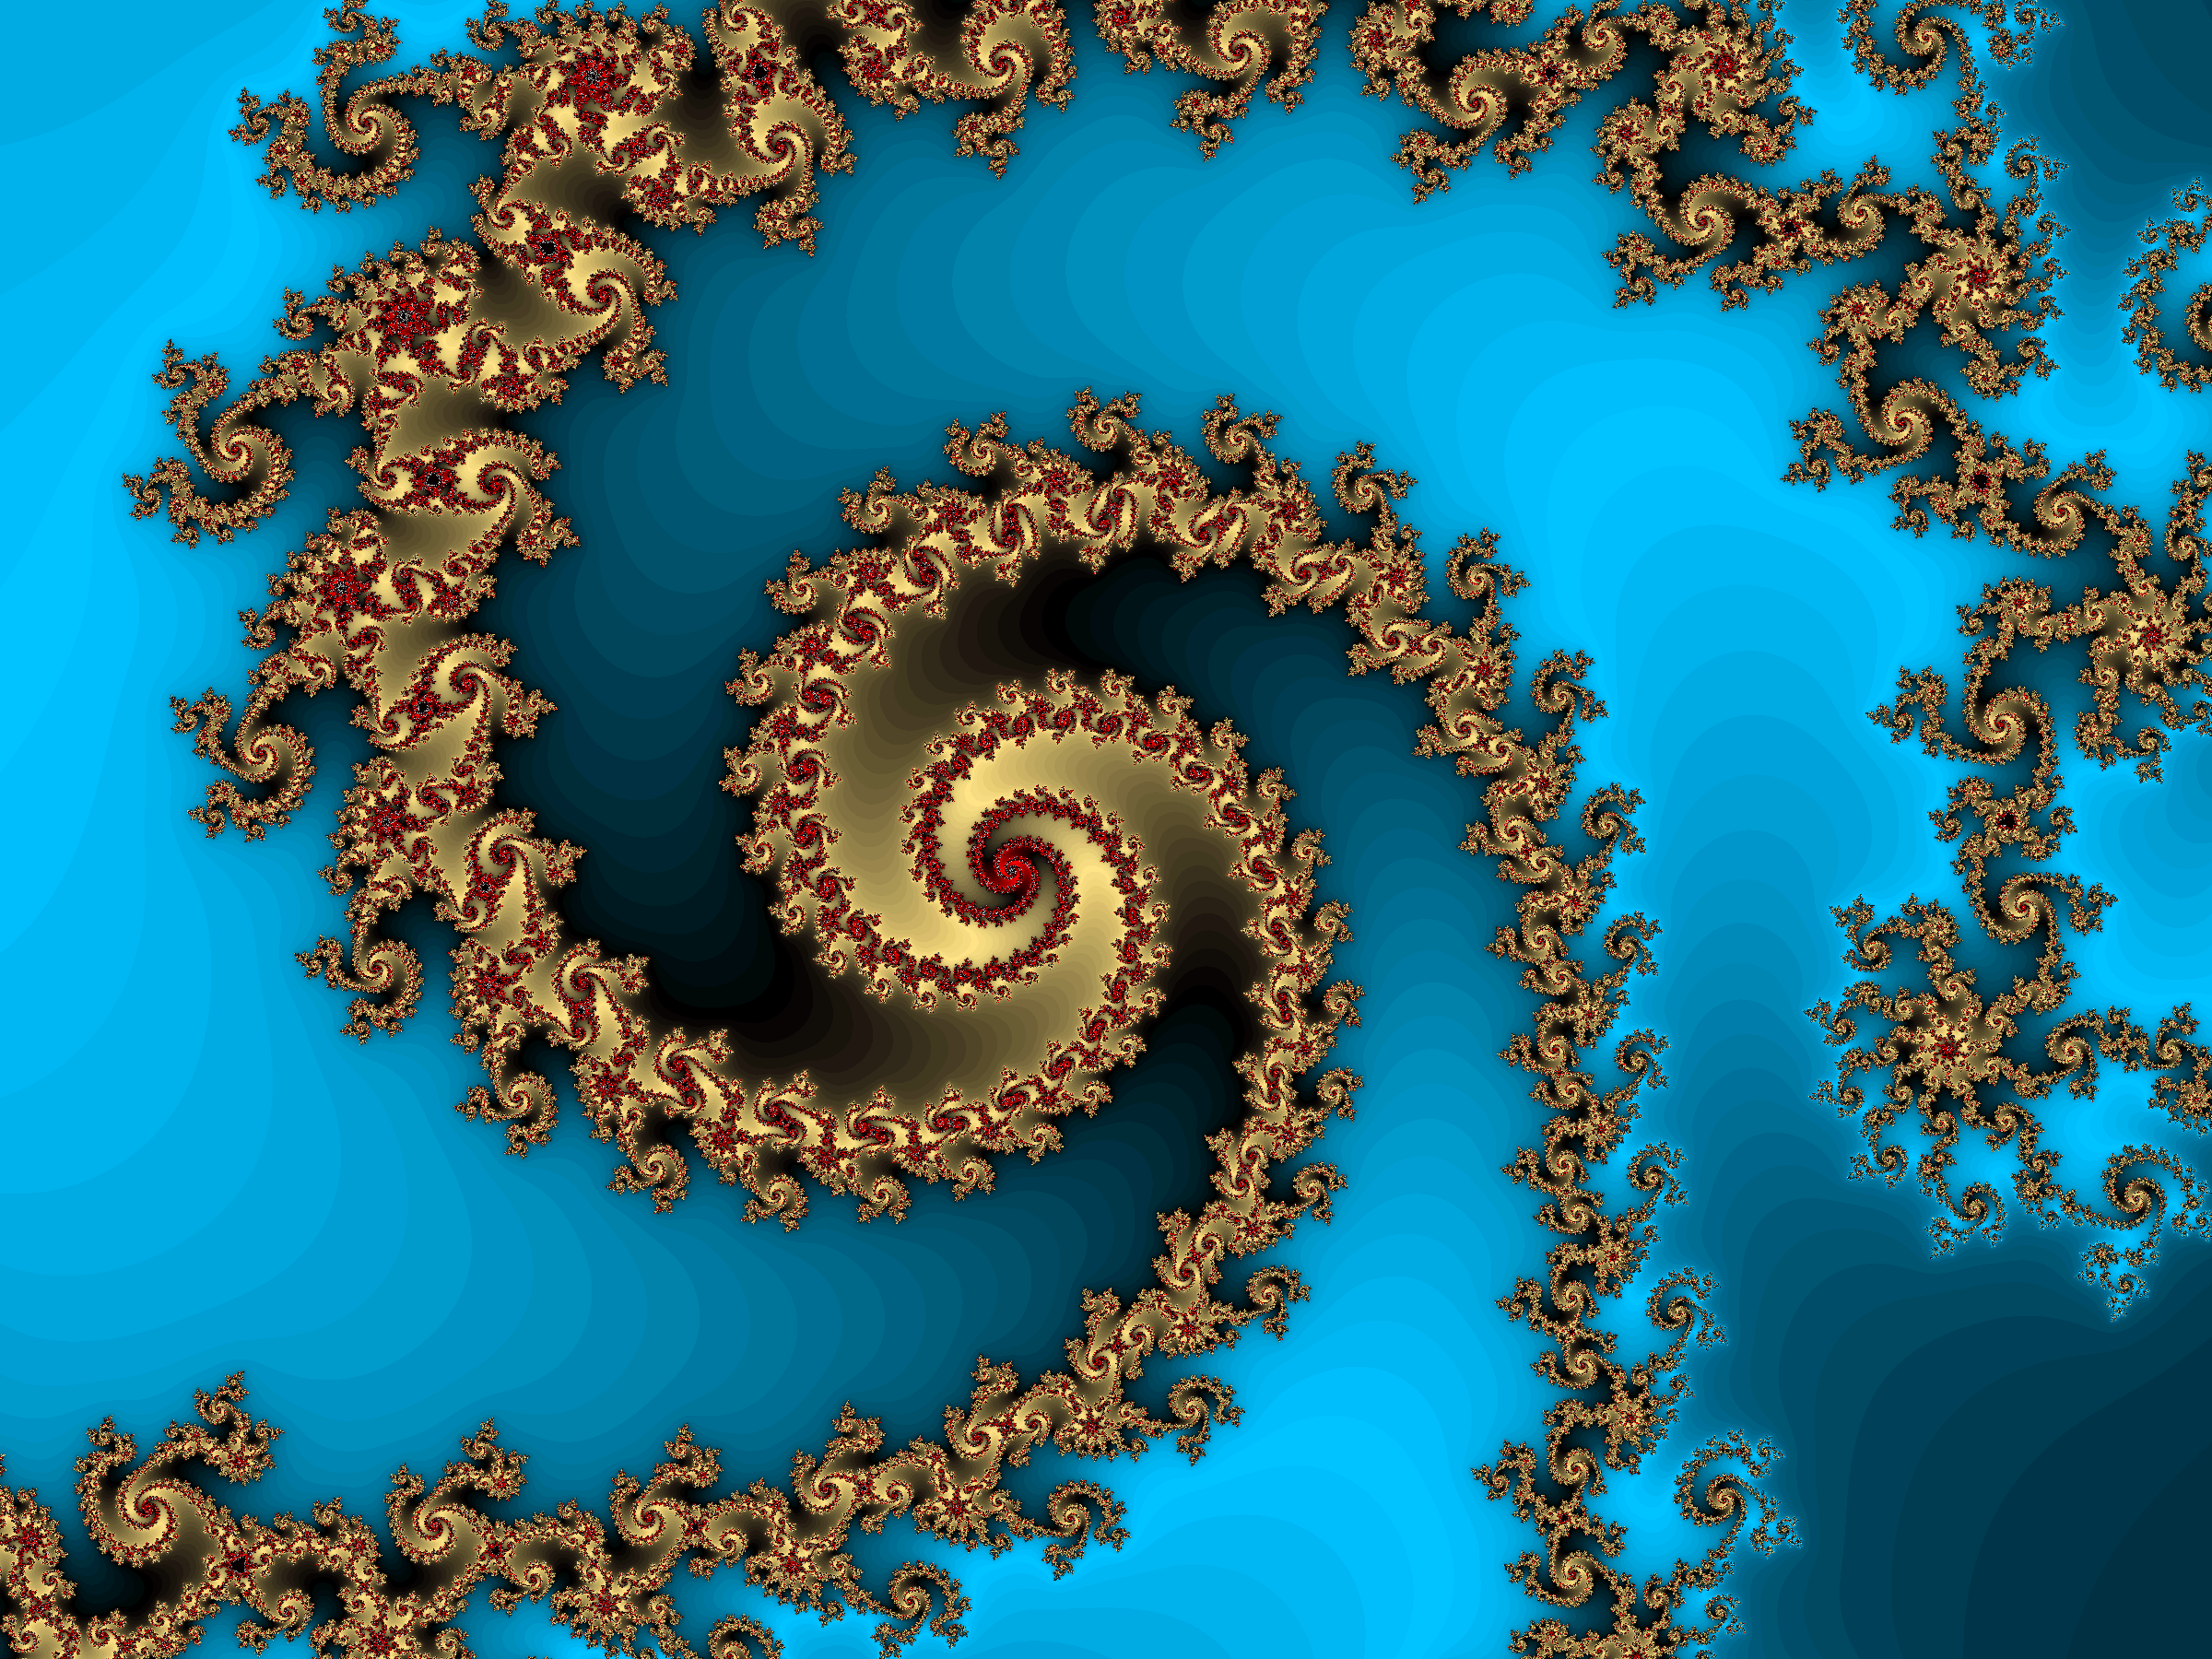

In [5]:
img = Image.open(path)
img

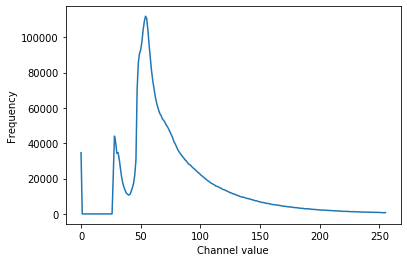

In [5]:
fig, ax = plt.subplots()
ax.plot(range(len(img.histogram())), img.histogram())
ax.set_ylabel("Frequency")
ax.set_xlabel("Channel value")
plt.show()

In [8]:
img = img.convert("RGB")

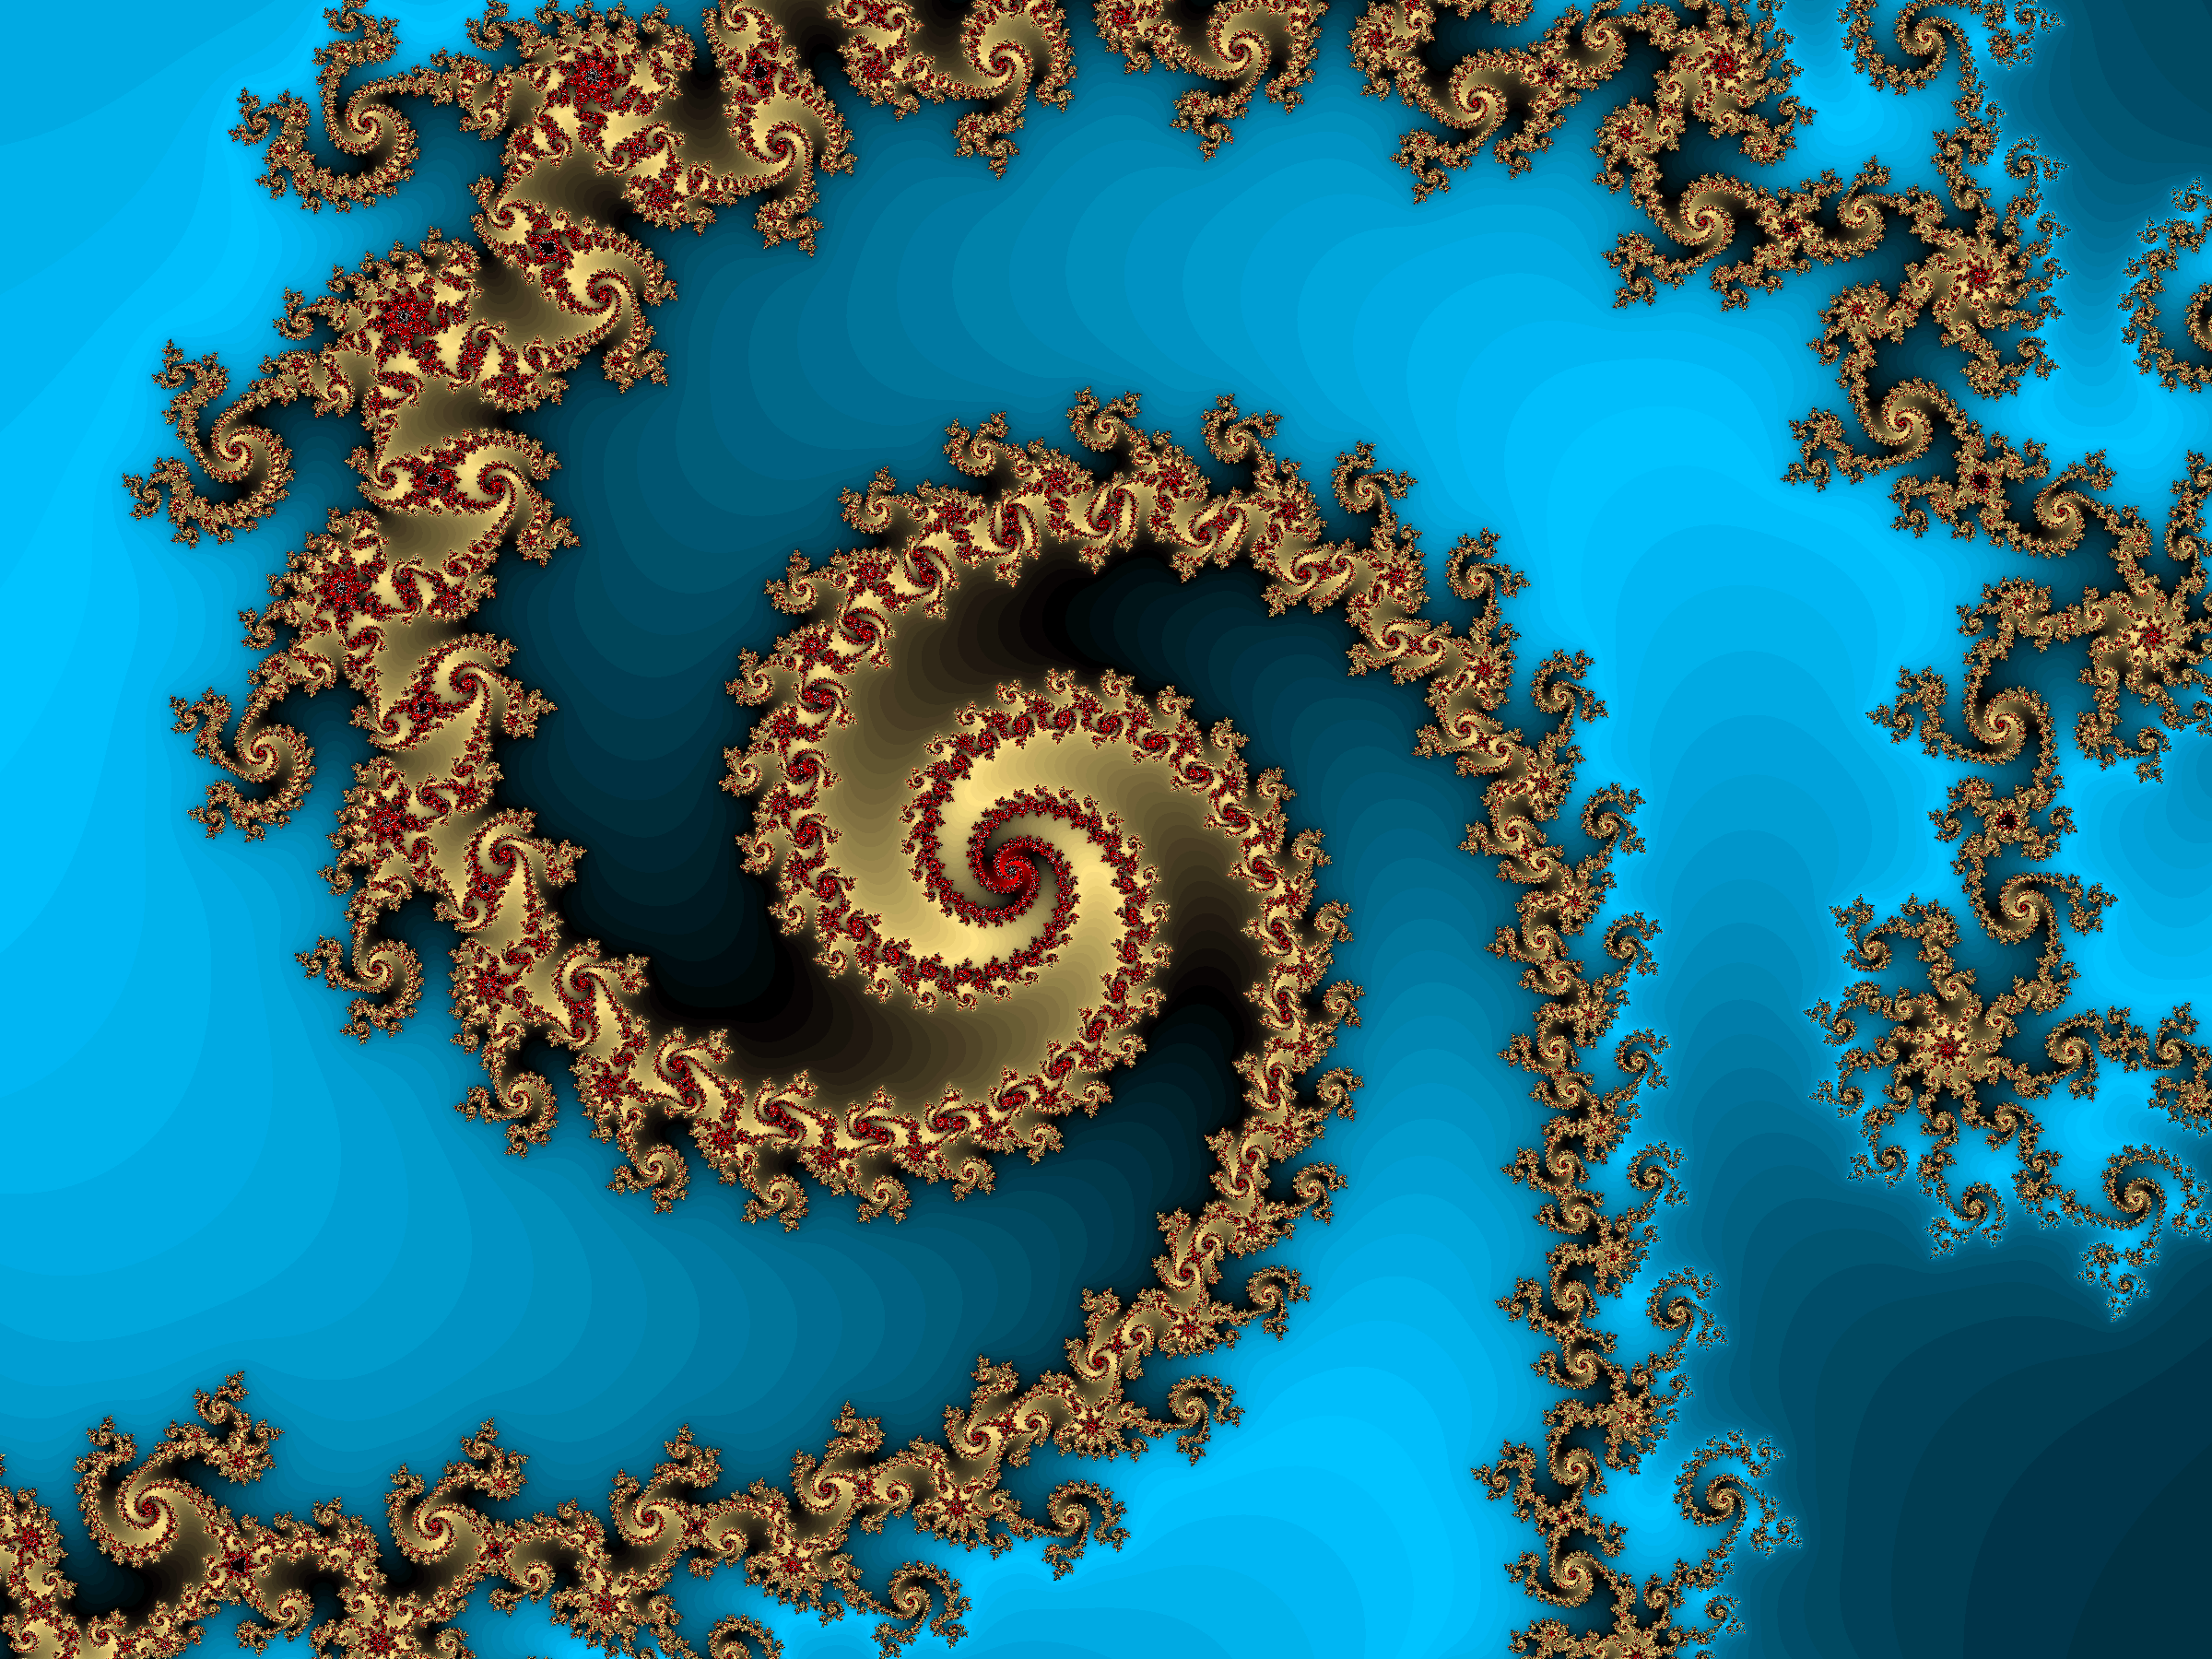

In [7]:
img

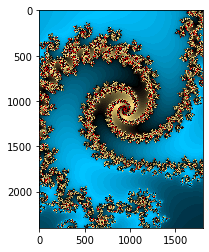

In [9]:
img_arr = np.asarray(img)
img_arr = np.transpose(img_arr, axes=(1,0,2))
# img_arr = np.transpose(img_arr, axes=(2,1,0))
fig, ax = plt.subplots()
ax.imshow(img_arr)
plt.show()

In [10]:
def img2tensor(img):
    img_arr = np.asarray(img)
    img_arr = np.transpose(img, axes=(1, 0, 2))
    img_arr = np.transpose(img, axes=(2, 1, 0))
    tens = torch.from_numpy(img_arr)
    return tens

img_tensor = img2tensor(img)
img_tensor.size()

torch.Size([3, 2400, 1800])

## 1. Components

### 1.1 Linear/Dense

In [10]:
img_tensor2d_flat = img_tensor[0].clone().flatten().float()

In [11]:
pi, = img_tensor2d_flat.size()
num_out = 100
weights = torch.randn((num_out, pi))
weights.size()

torch.Size([100, 4320000])

In [12]:
weights @ img_tensor2d_flat

tensor([-2.7171e+05, -1.9249e+05,  1.7298e+05,  2.5511e+04,  1.0155e+05,
         3.1065e+04, -2.0225e+05,  2.8086e+04,  1.0856e+05, -2.5256e+04,
        -1.4758e+05,  2.3340e+04,  1.2688e+05,  2.4197e+05, -1.3272e+05,
         3.0479e+05,  3.2944e+04, -1.4892e+05,  2.0884e+04,  1.0567e+05,
        -1.3943e+04, -1.8340e+05,  4.4131e+04, -1.1628e+05,  8.5479e+04,
        -5.5905e+04,  9.5120e+04,  1.1899e+05, -4.3712e+04,  1.5093e+05,
         1.0522e+05, -8.2423e+04, -9.4976e+04, -2.0327e+05,  1.7479e+05,
        -1.9533e+05,  4.6072e+04, -1.3886e+05,  1.1845e+05, -2.2247e+05,
         8.4112e+03, -2.4722e+05,  3.3862e+05, -1.4954e+05,  3.6056e+04,
         1.9679e+05, -5.8037e+04,  1.2922e+05, -1.7208e+05,  1.8925e+05,
        -1.0129e+05,  1.0577e+05, -8.1292e+04, -1.1187e+05,  6.4157e+03,
        -1.3063e+05,  2.0914e+05,  1.0982e+04, -7.4733e+04,  1.9794e+05,
         9.0676e+04, -6.5914e+04, -5.2093e+04,  6.7274e+04,  5.2919e+04,
        -2.4665e+04, -7.8567e+04,  2.4283e+05,  5.8

In [13]:
%timeit -r 10 weights @ img_tensor2d_flat

81.7 ms ± 3.26 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [14]:
%timeit -r 10 torch.einsum("ij,j->i", weights, img_tensor2d_flat)

79.9 ms ± 2.77 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


### 1.2 CNN

In [15]:
kernel = torch.zeros((3,3))
kernel[1,1] = 1
kernel

tensor([[0., 0., 0.],
        [0., 1., 0.],
        [0., 0., 0.]])

In [16]:
stride = 1

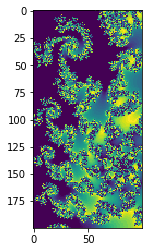

In [17]:
img_tensor2d = img_tensor[0, 500:700, :100].clone()
img_tensor2d = img_tensor2d.float()
plt.imshow(img_tensor2d)
plt.show()

In [18]:
I, J = img_tensor2d.size()
I = np.floor(I / stride).astype(int)
I -= kernel.size()[0] - 1
J = np.floor(J / stride).astype(int)
J -= kernel.size()[1] - 1
I, J

(198, 98)

In [25]:
def do_convolution(img, kernel):
    out = torch.zeros((I,J))
    #print(out.size(), out.size()[0]*out.size()[1])
    ki, kj = kernel.size()[0], kernel.size()[1]

    with torch.no_grad():
        for i in range(I):
            for j in range(J):
                t = img[i*stride : i*stride+ki, j*stride : j*stride+kj]
                out[i,j] = (t * kernel).sum()
    return out

out = do_convolution(img_tensor2d, kernel)

In [26]:
%timeit -r 10 do_convolution(img_tensor2d, kernel)

554 ms ± 23.4 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


cnn → matrix multiplication: [blog](https://medium.com/impactai/cnns-from-different-viewpoints-fab7f52d159c)

In [27]:
pi, pj = img_tensor2d.size()
ki, kj = kernel.size()
num_pixels = pi*pj
num_pixels_after = (pi//stride - ki + 1) * (pj//stride - kj + 1)
print("num_pixels", num_pixels, "num_pixels_after", num_pixels_after)
print("unrolled kernel size", num_pixels_after*num_pixels)
# unrolled_kernel = torch.zeros((, num_pixels))

num_pixels 20000 num_pixels_after 19404
unrolled kernel size 388080000


In [28]:
add_batch_and_channel = lambda x: x.unsqueeze(0).unsqueeze(0)
add_batch_and_channel(img_tensor2d).size()

torch.Size([1, 1, 200, 100])

In [29]:
_img_tensor2d = add_batch_and_channel(img_tensor2d)
_kernel = add_batch_and_channel(kernel)

In [30]:
def do_convolution_with_pytorch(img, kernel):
    out = torch.nn.functional.conv2d(input=img, 
                                     weight=kernel, stride=1, padding=0)[0,0,:,:]
    return out

out2 = do_convolution_with_pytorch(_img_tensor2d, _kernel)

In [31]:
%timeit  -r 10 do_convolution_with_pytorch(_img_tensor2d, _kernel)

114 µs ± 4.28 µs per loop (mean ± std. dev. of 10 runs, 10000 loops each)


Dang, using pytorch's `nn.functional.conv2d` we get a 5000x speedup compared to the naïve implementation!

In [53]:
555 / .108

5138.888888888889

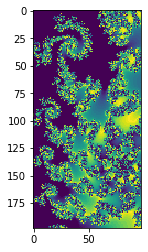

In [32]:
plt.imshow(out)
plt.show()

In [33]:
torch.isclose(out, out2).all()

tensor(True)

In [34]:
kernel = torch.randn((1, 3, 5, 5))
kernel

tensor([[[[-2.2313, -0.3996,  0.3197, -1.8570,  0.3237],
          [-1.9605,  0.0572,  0.1186,  2.1391,  0.5070],
          [ 0.7411, -1.1831, -1.5504,  0.4123,  0.3472],
          [-0.5113, -0.1280,  1.5287, -0.8126,  0.0201],
          [ 0.1889,  0.1224, -0.7751,  1.6129, -0.7463]],

         [[ 0.7418, -0.5673,  0.8480, -1.3086, -0.2012],
          [ 0.5751, -1.5932, -0.1841, -0.3274,  0.9002],
          [-0.1085,  0.2566,  2.0668,  0.8572, -0.0107],
          [-1.7928,  0.0112, -0.7580, -1.3726,  0.0886],
          [ 1.6400,  0.5020, -0.6333,  0.4987, -1.2829]],

         [[-1.1514,  0.2311, -0.4646, -0.5645, -0.5600],
          [-0.0986, -0.8927, -1.3569, -0.0298, -0.4144],
          [ 0.6169, -0.1621, -1.8858, -2.1710,  0.4132],
          [-0.4356, -1.7806, -0.1099, -0.4737,  0.3038],
          [-0.3401, -0.3891,  0.6778,  0.7709, -0.4222]]]])

In [35]:
out = torch.nn.functional.conv2d(input=img_tensor.unsqueeze(0).float(), weight=kernel, stride=1, padding=0)
out.size()

torch.Size([1, 1, 2396, 1796])

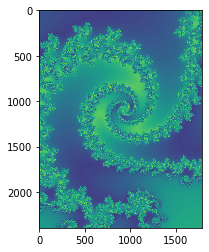

In [36]:
plt.imshow(out[0, 0, :, :])
plt.show()

## 1.3 Batch norm

References:
- original batch norm paper: https://arxiv.org/abs/1502.03167
- paper discussing batch norm effect: https://papers.nips.cc/paper/7515-how-does-batch-normalization-help-optimization
- blog on normalization in deep nets:https://arthurdouillard.com/post/normalization/

One interesting thing is that, when starting to play with basic RNNs further down in the notebook, one finds exploding or vanishing values. That's probably why when Jeremy demonstrated in the [lesson 7 notebook](https://nbviewer.jupyter.org/github/fastai/course-v3/blob/master/nbs/dl1/lesson7-human-numbers.ipynb) RNNs in conjunction with batch norm. So instead of looking at RNNs next I've put the batch norm first.

In [371]:
def relu(x): return torch.clamp_min(x, 0)

print(relu(torch.tensor([-1, -.1, 0, .2, .5])))

tensor([0.0000, 0.0000, 0.0000, 0.2000, 0.5000])


In [511]:
class BatchNorm(torch.nn.Module):
    
    running_mean: torch.Tensor = None
    running_variance: torch.Tensor = None
    
    def __init__(self, num_features:int, momentum: float, eps=1e-5):
        super().__init__()
        
        self.eps = eps
        self.num_features = num_features
        self.momentum = momentum
        self.init_bn_params()
        
    def init_bn_params(self):
        self.running_mean = torch.zeros(self.num_features)
        self.running_variance = torch.ones(self.num_features)
        self.bias = torch.nn.Parameter(torch.zeros(self.num_features))
        self.mul = torch.nn.Parameter(torch.ones(self.num_features))
        
    def forward(self, x):
        
        if self.training == True:
            self.running_mean = self.momentum*self.running_mean + (1.-self.momentum)*x.mean(dim=0)
            self.running_variance = self.momentum*self.running_variance + (1.-self.momentum)*x.pow(2).mean(dim=0) - self.running_mean*self.running_mean
        
        o = (x - self.running_mean)/torch.sqrt(self.running_variance + self.eps)
        return self.mul * o + self.bias
        

_, num_in = img_tensor2d.size()
num_hidden = num_in//2
eps = 1e-8
momentum = 0.
activations_archive = []

bs = 20
lin = torch.nn.Linear(in_features=num_in, out_features=num_hidden)

bn_ref = torch.nn.BatchNorm1d(num_hidden, momentum=momentum, eps=eps)
bn_new = BatchNorm(num_features=num_hidden, momentum=momentum, eps=eps)

bn_activations = []
relu_activations = []

with torch.no_grad():
    
    for j in range(3):
        print("\nj",j)
        x = img_tensor2d[j*bs:(j+1)*bs, :]
        
        # input -> hidden
        h = relu(lin(x))
        
        # batch norm
        o_ref = bn_ref(h)
        o_new = bn_new(h)
        print("o_ref", o_ref[:5,:5])
        print("o_new", o_new[:5,:5])
        Δ = (o_ref - o_new).detach().numpy().ravel()
        print(f"Δ: mean = {Δ.mean():.4f}, median = {np.median(Δ):.4f}")
        bn_activations.append(o_new)
        relu_activations.append(h)


j 0
o_ref tensor([[-0.6520, -0.2875, -0.7189, -0.3842,  0.3002],
        [-0.6520, -0.2875,  1.7609, -0.3842, -0.7628],
        [ 0.0990, -0.2875, -0.0559,  3.7985, -0.6081],
        [-0.6520, -0.2875, -0.1149, -0.3842, -0.7628],
        [ 0.3797, -0.2875,  3.0055, -0.3842, -0.7628]])
o_new tensor([[-0.6520, -0.2875, -0.7189, -0.3842,  0.3002],
        [-0.6520, -0.2875,  1.7609, -0.3842, -0.7628],
        [ 0.0990, -0.2875, -0.0559,  3.7985, -0.6081],
        [-0.6520, -0.2875, -0.1149, -0.3842, -0.7628],
        [ 0.3797, -0.2875,  3.0055, -0.3842, -0.7628]])
Δ: mean = -0.0000, median = 0.0000

j 1
o_ref tensor([[-0.6300, -0.3333, -1.0299, -0.2294,  1.0565],
        [-0.6300, -0.3333,  0.0337, -0.2294, -0.5534],
        [-0.6300, -0.3333, -1.0299, -0.2294, -0.5534],
        [-0.6300, -0.3333, -0.4956, -0.2294, -0.5534],
        [-0.6300, -0.3333, -0.7951, -0.2294, -0.5534]])
o_new tensor([[-0.6300, -0.3333, -1.0299, -0.2294,  1.0565],
        [-0.6300, -0.3333,  0.0337, -0.2294, -0.

In [516]:
next(iter(bn_new.named_parameters()))

('bias', Parameter containing:
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.], requires_grad=True))

The differences between pytorch's batch norm and the one implemented here (represented by Δ above) seems vanishingly small. That's great, now on to recurrent nets.

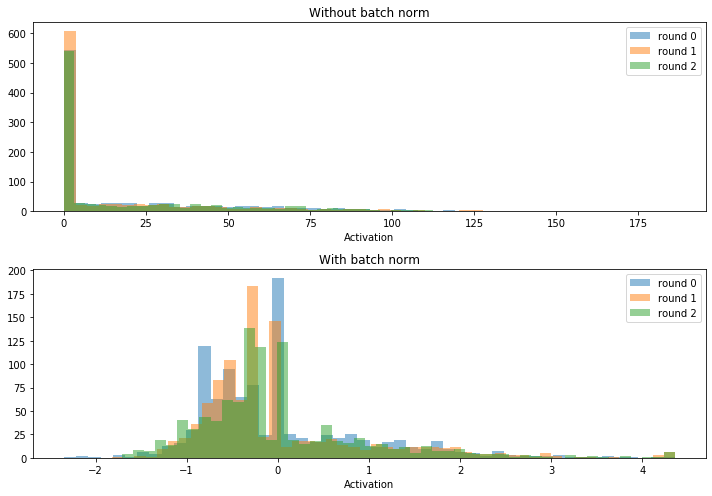

In [388]:
bins = 50

fig, axs = plt.subplots(nrows=2, figsize=(10,7))

ax = axs[0]
activations_ = torch.stack(relu_activations).detach().numpy()
for i in range(activations_.shape[0]):
    ax.hist(activations_[i].ravel(), bins=bins, label=f"round {i}", alpha=.5)
ax.set_xlabel("Activation")
ax.set_title("Without batch norm")
ax.legend()

ax = axs[1]
activations_ = torch.stack(bn_activations).detach().numpy()
for i in range(activations_.shape[0]):
    ax.hist(activations_[i].ravel(), bins=bins, label=f"round {i}", alpha=.5)
ax.set_xlabel("Activation")
ax.set_title("With batch norm")
ax.legend()


plt.tight_layout()
plt.show()

### 1.4 RNN

fastai course [lecture](https://www.fast.ai/2019/01/24/course-v3/)
corresponding [notebook](https://nbviewer.jupyter.org/github/fastai/course-v3/blob/master/nbs/dl1/lesson7-human-numbers.ipynb)

In [293]:
img_tensor2d = img_tensor[0, 500:700, :100].clone()
img_tensor2d = img_tensor2d.float()
img_tensor2d[0]

tensor([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 182.,   8.,   0.,
          0.,  97.,  56.,   8.,  16., 138., 113.,  32., 146.,   8., 166.,  36.,
         81., 235., 130.,  32., 146., 182., 207., 215., 231., 239., 231., 138.,
         48.,  32., 182., 223., 158., 138., 223., 203., 101., 223., 162., 154.,
        215., 130., 105., 154.])

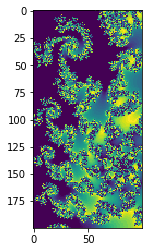

In [294]:
plt.imshow(img_tensor2d)
plt.show()

Setting up a data set, loader and bunch to simplify the prediction of pixel values using recurrent neural net components.

In [300]:
class Dataset:
    
    x: torch.Tensor = None
    lag: int = None
        
    def __init__(self, x: torch.Tensor, lag: int = 1):
        self.x = x
        self.lag = lag
    
    def __len__(self):
        return len(self.x) - self.lag
    
    def __getitem__(self, i):
        if isinstance(i, int):
            return self.x[i: i+self.lag].unsqueeze(0), self.x[i+1: i+1+self.lag].unsqueeze(0)
        if isinstance(i, slice):
            
            _x = torch.stack([self.x[_i:_i+self.lag] for _i in range(0 if i.start is None else i.start, 
                                                                     len(self.x) if i.stop is None else i.stop)])
            _y = torch.stack([self.x[_i+1:_i+self.lag+1] for _i in range(0 if i.start is None else i.start, 
                                                                     len(self.x) if i.stop is None else i.stop)])
            return _x, _y
        
    
class DataLoader:
    
    ds: Dataset = None
    bs: int = None
    
    def __init__(self, ds, bs):
        self.ds = ds
        self.bs = bs
        
    def __iter__(self):
        for i in range(len(self.ds)):
            yield self.ds[i:i+self.bs]
            
class DataBunch:
    "Bunches different data loaders"
    g: dict = {"train": None, "valid": None}
    
    def __init__(self, dl_train: DataLoader, dl_valid: DataLoader):
        self.dl_train = dl_train
        self.dl_valid = dl_valid
        
    def one_batch(self):
        return self.get_data(kind="train", reset_if_end=True)
    
    def reset_iterator(self, kind): self.g[kind] = iter(getattr(self, f"dl_{kind}"))
    
    def _get_data(self, kind: str = "train", reset: bool = True):
        if self.g[kind] is None or reset is True: 
            self.reset_iterator(kind)
        return next(self.g[kind], (None, None))
    
    def get_data(self, kind: str = "train", reset_if_end: bool = True):
        
        assert kind in self.g
        out = self._get_data(kind, reset_if_end)
        if out[0] is None and reset_if_end is True:
            return self._get_data(reset=True)
        if out[0] is None:
            raise StopIteration
        return out
            
# img_tensor2d_train = img_tensor[0, :img_tensor.size()[1]//2, :100].clone()
img_tensor2d_train = img_tensor[0, :img_tensor.size()[1]//2, 700:1000].clone()
img_tensor2d_train = img_tensor2d_train.float()

# img_tensor2d_valid = img_tensor[0, img_tensor.size()[1]//2:, :100].clone()
img_tensor2d_valid = img_tensor[0, img_tensor.size()[1]//2:, 700:1000].clone()
img_tensor2d_valid = img_tensor2d_valid.float()
    
lag = 4
bs = 20

ds_train = Dataset(img_tensor2d_train, lag=lag)
dl_train = DataLoader(ds_train, bs)
ds_valid = Dataset(img_tensor2d_valid, lag=lag)
dl_valid = DataLoader(ds_valid, bs)

# ds_train[:3]
db = DataBunch(dl_train=dl_train, dl_valid=dl_valid)

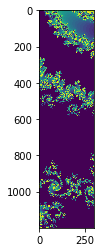

In [301]:
# plt.imshow(img_tensor2d_train);
plt.imshow(img_tensor2d_valid);

In [302]:
_x, _y = db.get_data("train")

In [303]:
class RNN(torch.nn.Module):
    
    hidden_state: torch.Tensor = None
        
    def __init__(self, num_in: int, num_hidden: int, keep_state: bool = False, return_all: bool = True,
                 use_batchnorm: bool = False):
        super().__init__()
        self.i2h = torch.nn.Linear(in_features=num_in, out_features=num_hidden)
        self.h2h = torch.nn.Linear(in_features=num_hidden, out_features=num_hidden)
        self.num_hidden = num_hidden
        self.keep_state = keep_state
        self.return_all = return_all
        self.use_batchnorm = use_batchnorm
        
        self.bn = torch.nn.BatchNorm1d(num_features=num_hidden, eps=1e-5)
        
    def _init_hidden(self, bs): self.hidden_state = torch.zeros((bs, self.num_hidden))
                
    def forward(self, x):
        
        bs, t = x.size()[:2]
        
        if not self.keep_state:
            self._init_hidden(bs)
        if self.return_all:
            res = torch.zeros_like(x)
        
        res = torch.zeros((bs, t, self.num_hidden))
        
        for i in range(t):
            
            self.hidden_state = self.i2h(x[:,i,:]) + self.h2h(self.hidden_state)
            self.hidden_state = torch.nn.functional.relu(self.hidden_state)
            if self.use_batchnorm: self.hidden_state = self.bn(self.hidden_state)
            if self.return_all:
                res[:,i,:] = self.hidden_state
        if self.return_all:
            return res
        return self.hidden_state.clone()
    
    def __call__(self, x):
        return self.forward(x)
    
num_in = img_tensor2d_train.size()[1]
num_hidden = num_in//2
print("num_in", num_in, "num_hidden", num_hidden)
print("bs", bs, "seq", lag)
m = RNN(num_in=num_in, num_hidden=num_hidden)
print("_x", _x.size())
out_new = m(_x)
print("out_new", out_new.size())

num_in 300 num_hidden 150
bs 20 seq 4
_x torch.Size([20, 4, 300])
out_new torch.Size([20, 4, 150])


Comparing against pytorch's [RNN](https://pytorch.org/docs/stable/nn.html?highlight=rnn#torch.nn.RNN) expects the input of dim `(seq_len, batch, input_size)`

In [304]:
r = torch.nn.RNN(input_size=num_in, hidden_size=num_hidden, nonlinearity="relu")
out_ref, h_n_ref = r(_x.transpose(1, 0))
out_ref.size(), h_n_ref.size()

(torch.Size([4, 20, 150]), torch.Size([1, 20, 150]))

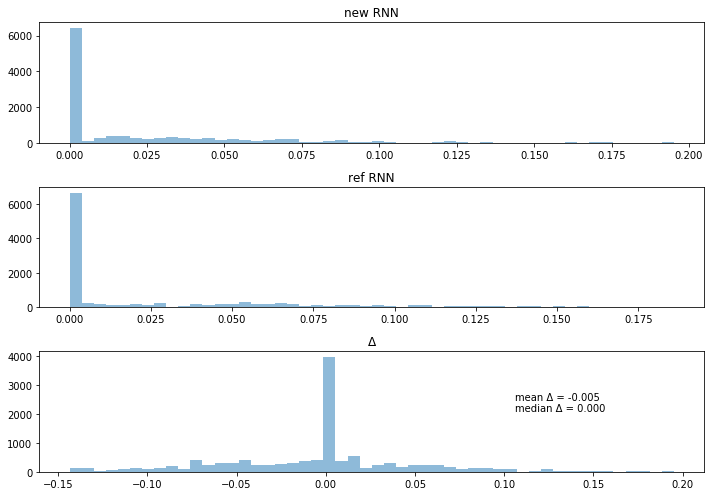

In [315]:
bins = 50

fig, axs = plt.subplots(nrows=3, figsize=(10, 7))
Δ = (out_new.detach().numpy() - out_ref.transpose(1, 0).detach().numpy()).ravel()
axs[0].hist(out_new.detach().numpy().ravel(), bins=bins, label="new", alpha=.5)
axs[0].set_title("new RNN")
axs[1].hist(out_ref.detach().numpy().ravel(), bins=bins, label="ref", alpha=.5)
axs[1].set_title("ref RNN")
axs[2].hist(Δ, bins=bins, label="Δ", alpha=.5)
axs[2].set_title("Δ")
axs[2].text(axs[2].get_xlim()[1]/2, axs[2].get_ylim()[1]/2, f"mean Δ = {Δ.mean():.3f}\nmedian Δ = {np.median(Δ):.3f}")
plt.tight_layout()
plt.show()

Excellent, value distributions of the outputs given the same input look very similar and the median and even the mean of the output differences between the two implementations of the RNN element are close to 0. This indicates the errors / differences in implementation are not too severe.

In [517]:
class Recorder:
    
    activations: dict = None
    parameters: dict = None
        
    def __init__(self):
        self.activations, self.parameters = {}, {}
        
    def _append(self, dict_name, key, val):
        if key not in getattr(self, dict_name):
            getattr(self, dict_name)[key] = []
        getattr(self, dict_name)[key].append(val.clone().detach().numpy())
        
    def _append_parameters(self, key, val): self._append("parameters", key, val)
        
    def append_parameters(self, m):
        for name, _p in m.named_parameters():
            self._append_parameters(name, _p)
        
    def append_activations(self, key, val): self._append("activations", key, val)

In [519]:
class Model(torch.nn.Module):
        
    def __init__(self, num_in: int, num_hidden: int, rec:Recorder, keep_state: bool=False, rnn_use_bn:bool=False):
        super().__init__()
        self.rnn = RNN(num_in=num_in, num_hidden=num_hidden, keep_state=keep_state, use_batchnorm=rnn_use_bn)
        self.h2o = torch.nn.Linear(in_features=num_hidden, out_features=num_in)
        self.rec = rec
        
    def forward(self, x: torch.Tensor):
        
        self.rec.append_parameters(self)
            
        a = self.rnn(x)
        self.rec.append_activations("rnn", a)
        a = self.h2o(a)
        self.rec.append_activations("h2o", a)
        a = torch.sigmoid(a)
        self.rec.append_activations("sigmoid", a)
        return a*255.
    
num_in=img_tensor2d_train.size()[1]
num_hidden=img_tensor2d_train.size()[1]//2

model = Model(num_in=num_in, num_hidden=num_hidden, rec=Recorder(), rnn_use_bn=False)

model(_x)

tensor([[[2.5500e+02, 2.5425e+02, 2.5500e+02,  ..., 2.5500e+02,
          2.5500e+02, 6.0709e-07],
         [2.5500e+02, 8.1364e-03, 2.5500e+02,  ..., 2.4914e+02,
          2.5500e+02, 1.7414e-17],
         [2.5500e+02, 1.4539e-06, 2.5500e+02,  ..., 8.1154e-05,
          2.5500e+02, 1.6453e-19],
         [2.5500e+02, 8.8142e-01, 2.5500e+02,  ..., 6.8900e+01,
          2.5500e+02, 2.4792e-09]],

        [[2.5500e+02, 2.5500e+02, 2.5500e+02,  ..., 2.5500e+02,
          2.5500e+02, 6.6004e-12],
         [2.5500e+02, 1.1305e-05, 2.5500e+02,  ..., 6.6253e-01,
          2.5500e+02, 4.8466e-13],
         [2.5500e+02, 1.6788e-01, 2.5500e+02,  ..., 1.2481e+00,
          2.5500e+02, 4.1618e-09],
         [2.5500e+02, 4.1392e-05, 2.5500e+02,  ..., 1.5911e-02,
          2.5500e+02, 7.4482e-19]],

        [[2.5500e+02, 2.5228e+02, 2.5497e+02,  ..., 2.5486e+02,
          2.5500e+02, 3.3976e-07],
         [2.5500e+02, 1.1959e-02, 2.5500e+02,  ..., 2.5456e+02,
          2.5500e+02, 9.0668e-02],
      

In [520]:
n_iters = 100
opt = torch.optim.Adam(params=model.parameters(), lr=.01)

In [521]:
losses = {"train": [], "valid": []}

for i in range(n_iters):
    _x, _y = db.get_data("train")
    _y_pred = model(_x)
    loss = (_y_pred-_y).pow(2).mean()
    losses["train"].append(loss.item())
    loss.backward()
    opt.step()
    
    with torch.no_grad():
        _x, _y = db.get_data("valid")
        _y_pred = model(_x)
        loss = (_y_pred-_y).pow(2).mean()
        losses["valid"].append(loss.item())

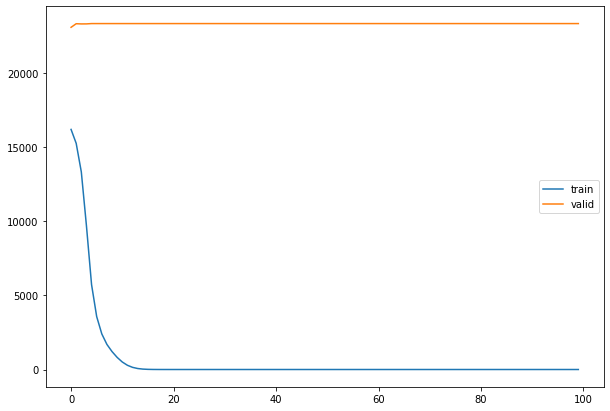

In [522]:
fig, ax = plt.subplots(figsize=(10,7))
for k in sorted(losses):
    ax.plot(np.arange(n_iters), losses[k], label=k)
ax.legend()
plt.show()

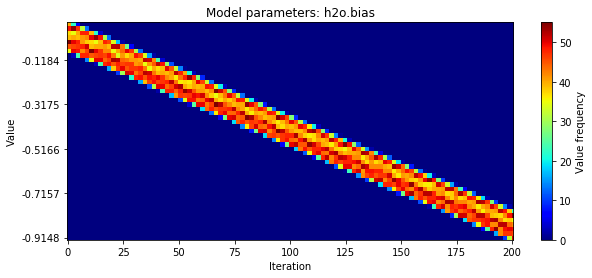

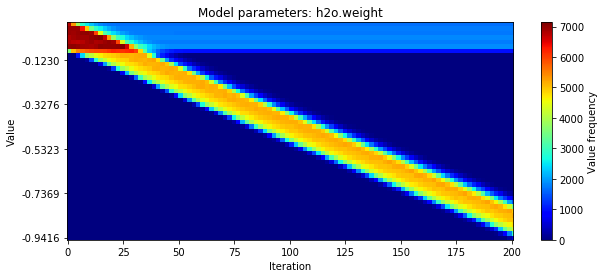

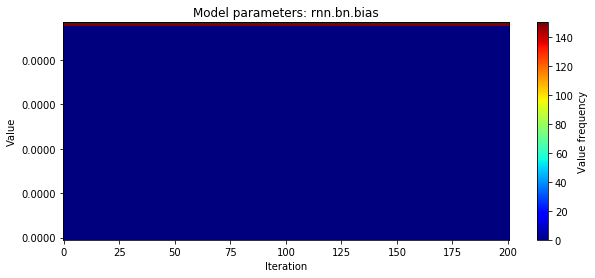

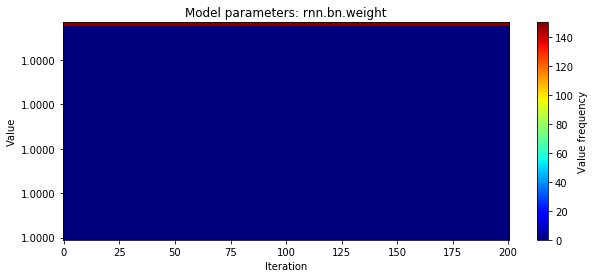

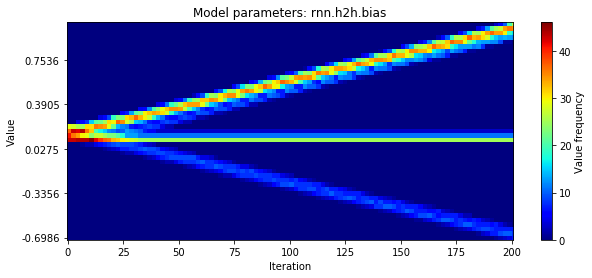

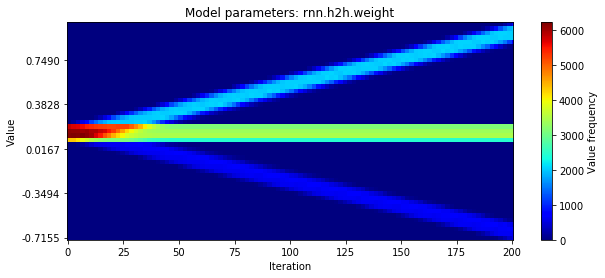

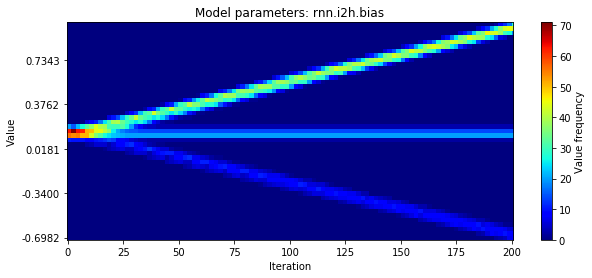

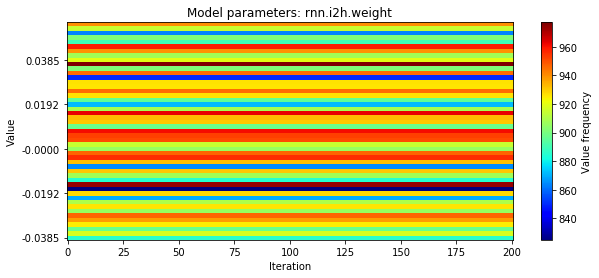

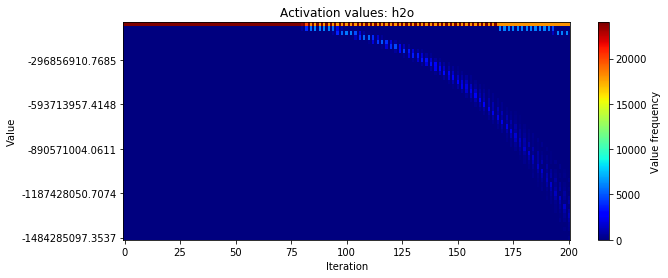

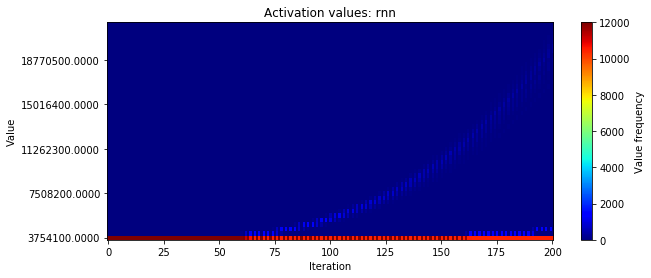

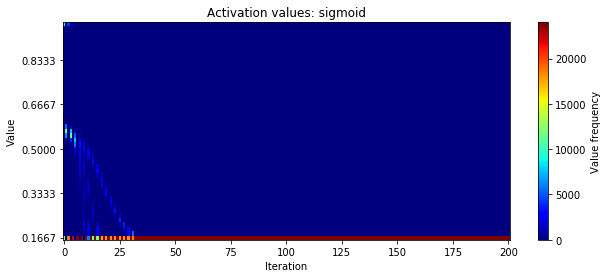

In [523]:
class Plotter:
    
    rec: Recorder = None
        
    def __init__(self, rec):
        self.rec = rec
        
    def plot_parameters(self, bins:int=50):
        
        for pname in sorted(self.rec.parameters):
            
            f = self.rec.parameters[pname]
            f = np.array([_f.ravel() for _f in f])
            _range = np.linspace(f.min(), f.max(), bins)
            f = np.array([np.histogram(_f, bins=_range)[0] for _f in f])
            
            fig, ax = plt.subplots(figsize=(10,4))
            im = ax.imshow(f.T, vmin=f.min(), vmax=f.max(), cmap="jet", origin="lowest", aspect="auto")
            cb = ax.figure.colorbar(im, ax=ax)
            cb.ax.set_ylabel("Value frequency")
            ax.set_title(f"Model parameters: {pname}")
            ax.set_xlabel("Iteration")
            ax.set_ylabel("Value")
            new_yticks = np.linspace(_range[0], _range[-1], len(ax.get_yticklabels()))
            ax.set_yticklabels([f"{v:.4f}" for v in new_yticks])
            plt.show()
            
    def plot_activations(self, bins:int=50):
        
        for aname in sorted(self.rec.activations):
            
            f = self.rec.activations[aname]
            f = np.array([_f.ravel() for _f in f])
            _range = np.linspace(f.min(), f.max(), bins)
            f = np.array([np.histogram(_f, bins=_range)[0] for _f in f])
            
            fig, ax = plt.subplots(figsize=(10,4))
            im = ax.imshow(f.T, vmin=f.min(), vmax=f.max(), cmap="jet", origin="lowest", aspect="auto")
            cb = ax.figure.colorbar(im, ax=ax)
            cb.ax.set_ylabel("Value frequency")
            ax.set_title(f"Activation values: {aname}")
            ax.set_xlabel("Iteration")
            ax.set_ylabel("Value")
            new_yticks = np.linspace(_range[0], _range[-1], len(ax.get_yticklabels()))
            ax.set_yticklabels([f"{v:.4f}" for v in new_yticks])
            plt.show()
            
pl = Plotter(model.rec)
pl.plot_parameters()
pl.plot_activations()

In [320]:
def get_sample(img, lag:int):
    s = img[-lag:, :].unsqueeze(0)
    
    return s
    
img_tensor2d_pred = img_tensor2d_valid.clone()
sample = get_sample(img_tensor2d_valid, lag=lag)
# model.rnn.bn.eval()
model.eval()

model(sample).size()

torch.Size([1, 4, 300])

Predicting new rows of pixel values

In [322]:
n_pred = 100
img_tensor2d_pred.size()

for i in range(n_pred):
    sample = get_sample(img_tensor2d_valid, lag=lag)
    new_row = model(sample)[:,-1,:]
    img_tensor2d_pred = torch.cat((img_tensor2d_pred, new_row), dim=0)
    
img_tensor2d_pred.size()

fig, ax = plt.subplots(figsize=(7,16))
ax.imshow(img_tensor2d_pred.detach().numpy())
plt.show()

torch.Size([1300, 300])

## 1.5 LSTM

So the equation in the pytorch docs [here](https://pytorch.org/docs/stable/nn.html#lstm) does not really specify clearly which matrix has which size. Apparently the image below from [this](https://www.quora.com/In-LSTM-how-do-you-figure-out-what-size-the-weights-are-supposed-to-be) Quora post is one way to visualize what's going on:
![LSTM matrix sizes](https://qph.fs.quoracdn.net/main-qimg-35aed4af6522aa361ead54cb571df52a)

Actually I found the list of the matrices more helpful. There you can see that essentially everything casts into $\mathbb{R}^{\text{num_hidden}}$. This means that all `torch.nn.Linear` operating on the input `x` are initialized as `torch.nn.Linear(in_features=num_in, out_features=num_hidden)` and all other as `torch.nn.Linear(in_features=num_hidden, out_features=num_hidden)`.

In [492]:
class LSTM(torch.nn.Module):
    
    hidden_state: torch.Tensor = None
    cell_state: torch.Tensor = None
        
    def __init__(self, num_in: int, num_hidden: int, keep_state: bool = False, return_all: bool = True,
                 use_batchnorm: bool = False):
        super().__init__()
        
        self.i2i = torch.nn.Linear(in_features=num_in, out_features=num_hidden)
        self.h2i = torch.nn.Linear(in_features=num_hidden, out_features=num_hidden)
        self.i2f = torch.nn.Linear(in_features=num_in, out_features=num_hidden)
        self.h2f = torch.nn.Linear(in_features=num_hidden, out_features=num_hidden)
        self.i2g = torch.nn.Linear(in_features=num_in, out_features=num_hidden)
        self.h2g = torch.nn.Linear(in_features=num_hidden, out_features=num_hidden)
        self.i2o = torch.nn.Linear(in_features=num_in, out_features=num_hidden)
        self.h2o = torch.nn.Linear(in_features=num_hidden, out_features=num_hidden)
        
        self.num_hidden = num_hidden
        self.keep_state = keep_state
        self.return_all = return_all
        self.use_batchnorm = use_batchnorm
        
        self.bn = torch.nn.BatchNorm1d(num_features=num_hidden, eps=1e-5)
        
    def _init_hidden(self, bs): self.hidden_state = torch.zeros((bs, self.num_hidden))
        
    def _init_cell(self, bs): self.cell_state = torch.zeros((bs, self.num_hidden))
                
    def forward(self, x):
        # following the math in https://pytorch.org/docs/stable/nn.html#lstm
                
        bs, t = x.size()[:2]
        
        if not self.keep_state:
            self._init_hidden(bs)
            self._init_cell(bs)
            
        if self.return_all:
            res = torch.zeros_like(x)
        
        res = torch.zeros((bs, t, self.num_hidden))
        
        σ = torch.sigmoid
        tanh = torch.tanh
        
        for i in range(t):
            
            # input gate
            it = σ(self.i2i(x[:,i,:]) + self.h2i(self.hidden_state))
            # forget gate
            ft = σ(self.i2f(x[:,i,:]) + self.h2f(self.hidden_state))
            # cell gate
            gt = tanh(self.i2g(x[:,i,:]) + self.h2g(self.hidden_state))
            # output gate
            ot = σ(self.i2o(x[:,i,:]) + self.h2o(self.hidden_state))
            
            # update cell state
            self.cell_state = ft * self.cell_state + it * gt
            # update hidden state
            self.hidden_state = ot * tanh(self.cell_state)
                        
            if self.use_batchnorm: self.hidden_state = self.bn(self.hidden_state)
            if self.return_all:
                res[:,i,:] = self.hidden_state
        if self.return_all:
            return res
        return self.hidden_state.clone()
    
    def __call__(self, x):
        return self.forward(x)
    
_x, _y = db.get_data("train")
    
num_in = img_tensor2d_train.size()[1]
num_hidden = num_in//2
print("num_in", num_in, "num_hidden", num_hidden)
print("bs", bs, "seq", lag)
m = LSTM(num_in=num_in, num_hidden=num_hidden)
print("_x", _x.size())
out_new = m(_x)
print("out_new", out_new.size())

num_in 300 num_hidden 150
bs 20 seq 4
_x torch.Size([20, 4, 300])
out_new torch.Size([20, 4, 150])


Comparing against pytorch's [LSTM](https://pytorch.org/docs/stable/nn.html#lstm) expects the input of dim `(seq_len, batch, input_size)`

In [493]:
m = torch.nn.LSTM(input_size=num_in, hidden_size=num_hidden)
out_ref, (h_n_ref, c_n_ref) = m(_x.transpose(1, 0))
out_ref.size(), h_n_ref.size(), c_n_ref.size()

(torch.Size([4, 20, 150]), torch.Size([1, 20, 150]), torch.Size([1, 20, 150]))

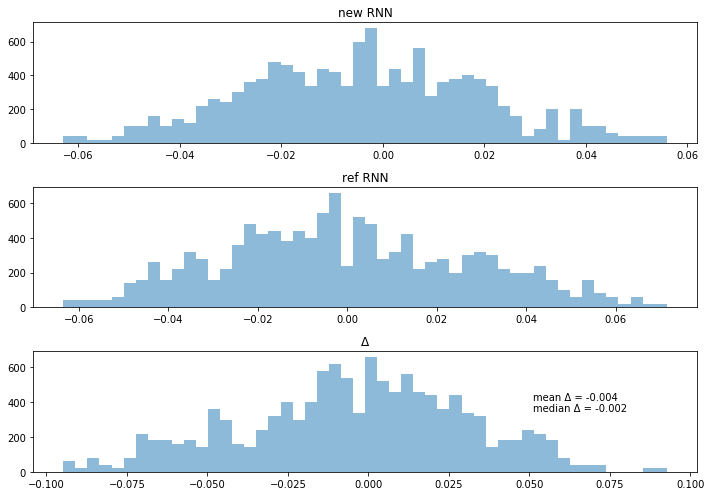

In [494]:
bins = 50

fig, axs = plt.subplots(nrows=3, figsize=(10, 7))
Δ = (out_new.detach().numpy() - out_ref.transpose(1, 0).detach().numpy()).ravel()
axs[0].hist(out_new.detach().numpy().ravel(), bins=bins, label="new", alpha=.5)
axs[0].set_title("new RNN")
axs[1].hist(out_ref.detach().numpy().ravel(), bins=bins, label="ref", alpha=.5)
axs[1].set_title("ref RNN")
axs[2].hist(Δ, bins=bins, label="Δ", alpha=.5)
axs[2].set_title("Δ")
axs[2].text(axs[2].get_xlim()[1]/2, axs[2].get_ylim()[1]/2, f"mean Δ = {Δ.mean():.3f}\nmedian Δ = {np.median(Δ):.3f}")
plt.tight_layout()
plt.show()

Excellent, value distributions of the outputs given the same input look very similar and the median and even the mean of the output differences between the two implementations of the LSTM element are close to 0. This indicates the errors / differences in implementation are not too severe.

In [524]:
class Model(torch.nn.Module):
        
    def __init__(self, num_in: int, num_hidden: int, rec:Recorder, keep_state: bool=False, rnn_use_bn:bool=False):
        super().__init__()
        self.lstm = LSTM(num_in=num_in, num_hidden=num_hidden, keep_state=keep_state, use_batchnorm=rnn_use_bn)
        self.h2o = torch.nn.Linear(in_features=num_hidden, out_features=num_in)
        self.rec = rec
        
    def forward(self, x: torch.Tensor):
        
        self.rec.append_parameters(self)
            
        a = self.lstm(x)
        self.rec.append_activations("hidden_state", self.lstm.hidden_state)
        self.rec.append_activations("cell_state", self.lstm.cell_state)
        self.rec.append_activations("lstm", a)
        a = self.h2o(a)
        self.rec.append_activations("h2o", a)
        a = torch.sigmoid(a)
        self.rec.append_activations("sigmoid", a)
        return a*255.
    
num_in=img_tensor2d_train.size()[1]
num_hidden=img_tensor2d_train.size()[1]//2

model = Model(num_in=num_in, num_hidden=num_hidden, rec=Recorder(), rnn_use_bn=False)

model(_x)

tensor([[[160.1540, 122.9577, 126.7260,  ..., 112.4683, 142.0371, 128.7165],
         [139.6768, 124.7128, 138.4625,  ..., 127.0942, 138.2742, 127.6112],
         [142.2030, 120.0371, 131.8001,  ..., 113.6213, 130.7058, 115.6579],
         [149.0600, 121.1104, 141.7620,  ..., 118.4620, 142.2091, 117.0520]],

        [[131.4245, 121.6343, 137.6813,  ..., 129.3607, 140.2170, 120.1573],
         [139.0361, 117.6247, 132.9302,  ..., 113.0874, 134.4246, 114.2175],
         [143.8288, 118.4786, 146.3765,  ..., 120.1755, 141.9271, 112.0722],
         [150.5828, 122.3047, 142.7782,  ..., 127.1935, 144.7196, 126.9493]],

        [[136.6963, 118.4160, 131.1960,  ..., 114.9852, 136.1762, 116.3292],
         [147.1707, 118.8772, 143.2746,  ..., 121.1663, 148.2616, 114.4347],
         [152.4723, 122.7539, 142.5704,  ..., 129.7542, 148.1862, 126.6973],
         [144.8954, 127.9281, 140.2608,  ..., 124.6607, 130.3430, 132.9721]],

        ...,

        [[165.3868, 142.4243, 100.1622,  ..., 133.7684, 

In [525]:
n_iters = 100
opt = torch.optim.Adam(params=model.parameters(), lr=.01)

In [526]:
losses = {"train": [], "valid": []}

for i in range(n_iters):
    _x, _y = db.get_data("train")
    _y_pred = model(_x)
    loss = (_y_pred-_y).pow(2).mean()
    losses["train"].append(loss.item())
    loss.backward()
    opt.step()
    
    with torch.no_grad():
        _x, _y = db.get_data("valid")
        _y_pred = model(_x)
        loss = (_y_pred-_y).pow(2).mean()
        losses["valid"].append(loss.item())

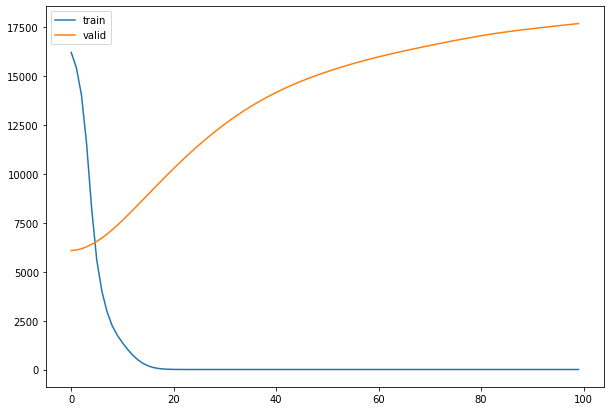

In [527]:
fig, ax = plt.subplots(figsize=(10,7))
for k in sorted(losses):
    ax.plot(np.arange(n_iters), losses[k], label=k)
ax.legend()
plt.show()

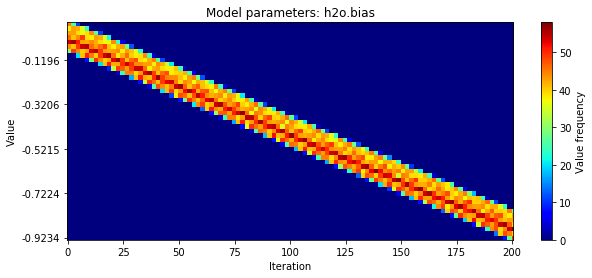

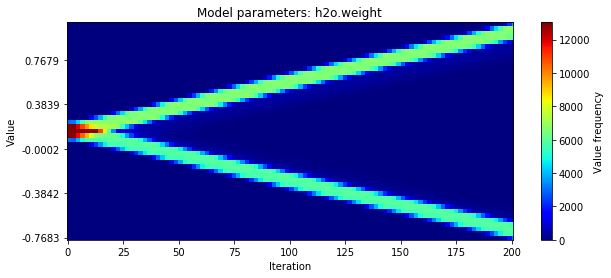

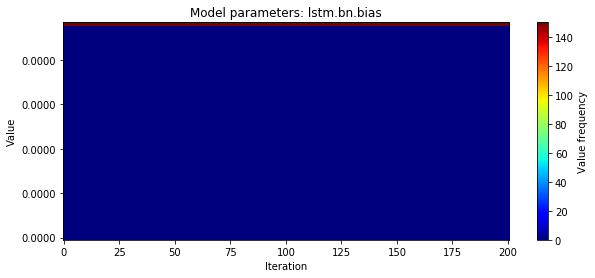

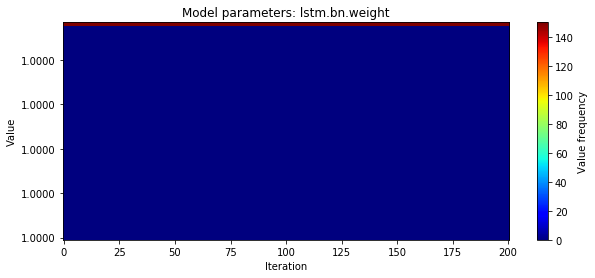

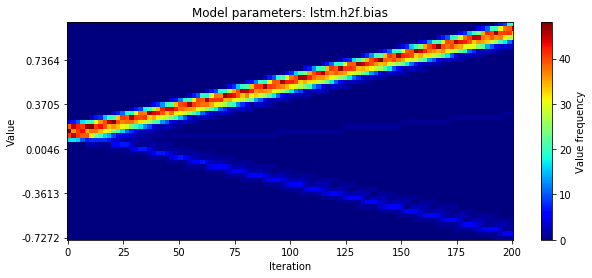

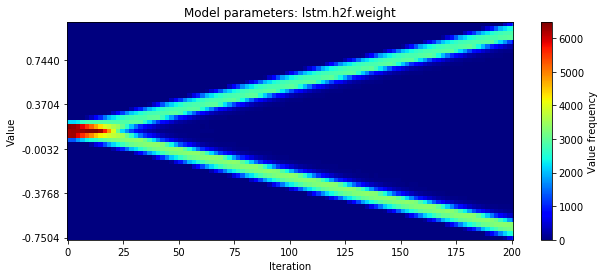

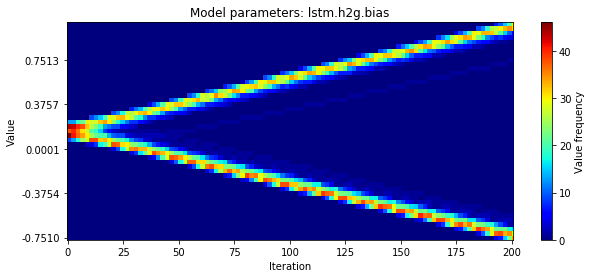

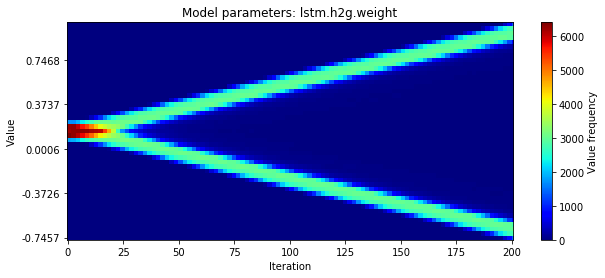

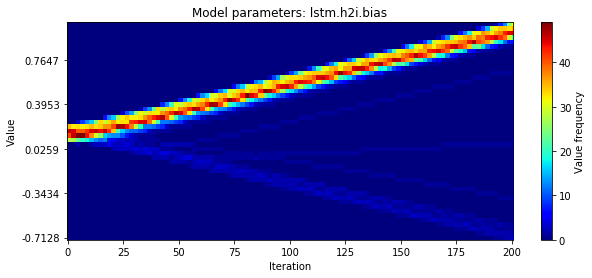

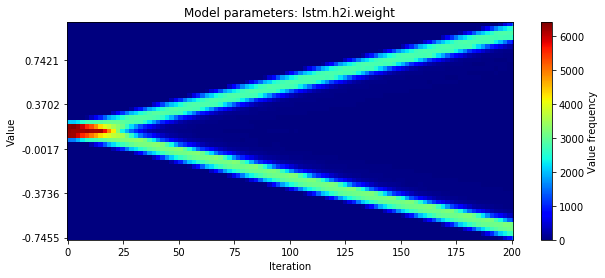

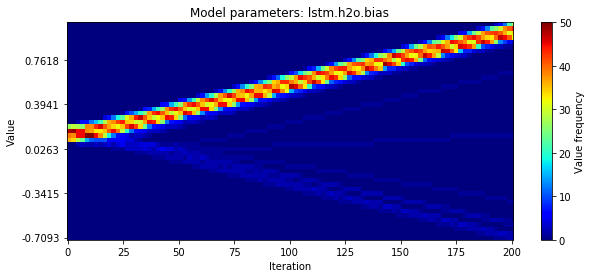

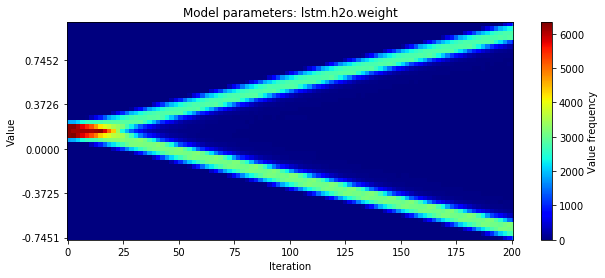

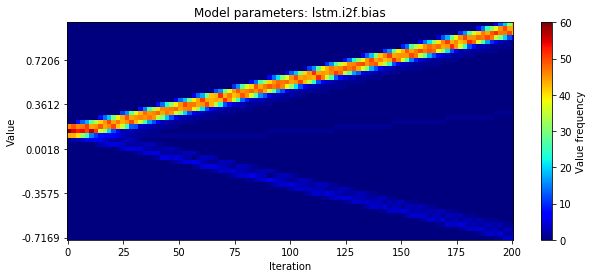

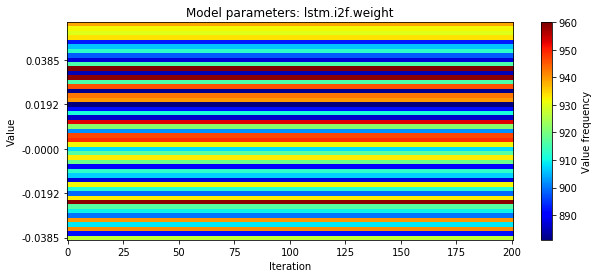

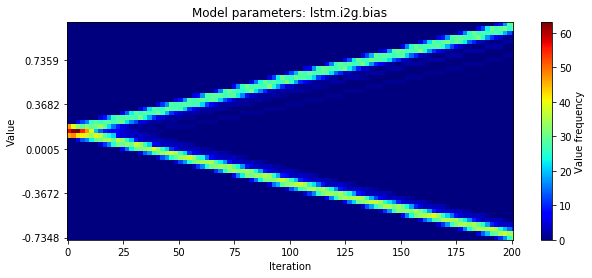

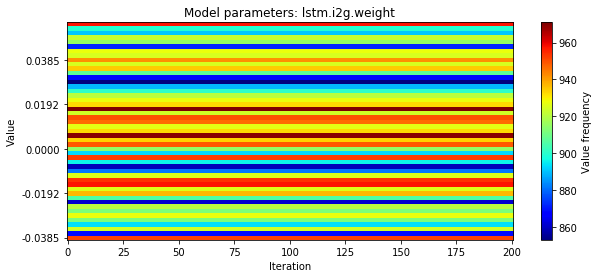

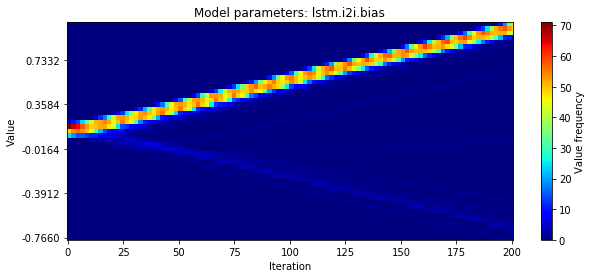

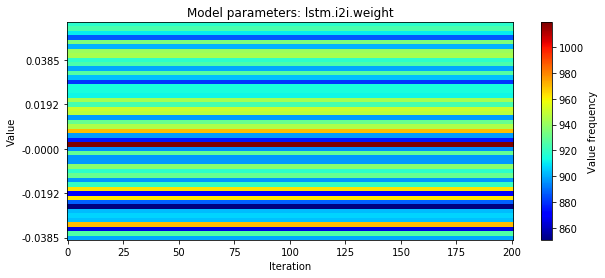

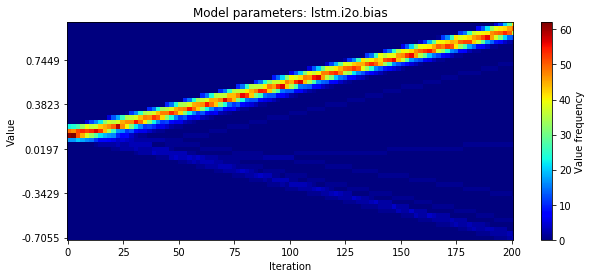

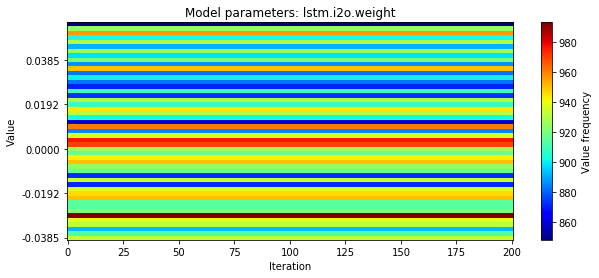

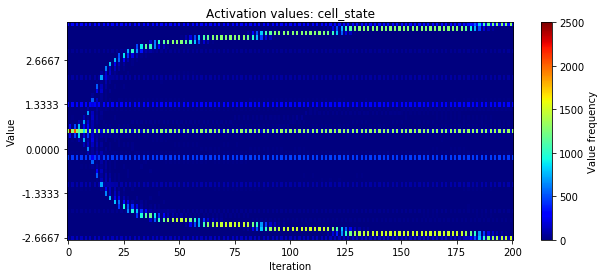

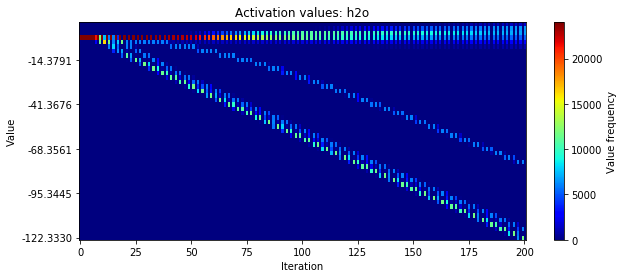

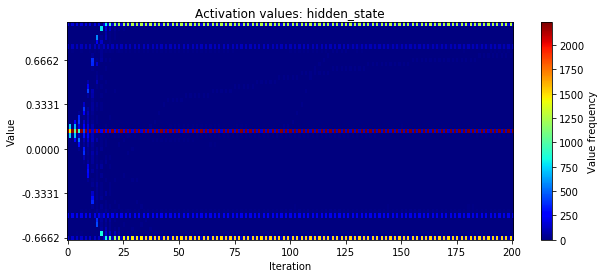

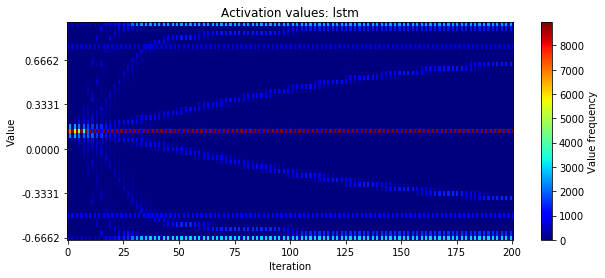

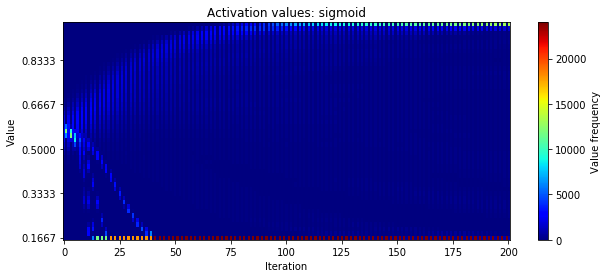

In [528]:
pl = Plotter(model.rec)
pl.plot_parameters()
pl.plot_activations()

Predicting next rows of pixel values

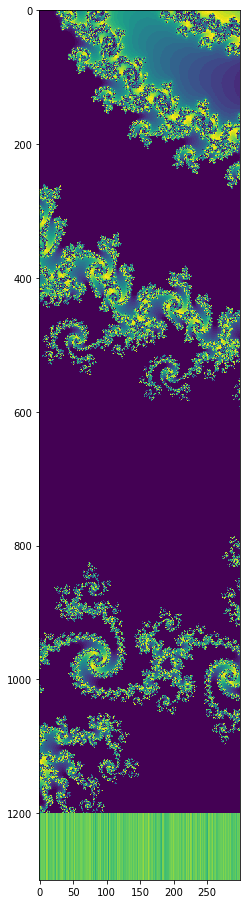

In [407]:
n_pred = 100
img_tensor2d_pred = img_tensor2d_valid.clone()
img_tensor2d_pred.size()

for i in range(n_pred):
    sample = get_sample(img_tensor2d_valid, lag=lag)
    new_row = model(sample)[:,-1,:]
    img_tensor2d_pred = torch.cat((img_tensor2d_pred, new_row), dim=0)
    
img_tensor2d_pred.size()

fig, ax = plt.subplots(figsize=(7,16))
ax.imshow(img_tensor2d_pred.detach().numpy())
plt.show()

## 1.6 Gated Recurrent Unit

The pytorch docs on this can be found [here](https://pytorch.org/docs/stable/nn.html#gru).

In [408]:
class GRU(torch.nn.Module):
    
    hidden_state: torch.Tensor = None
        
    def __init__(self, num_in: int, num_hidden: int, keep_state: bool = False, return_all: bool = True,
                 use_batchnorm: bool = False):
        super().__init__()
        
        self.i2r = torch.nn.Linear(in_features=num_in, out_features=num_hidden)
        self.h2r = torch.nn.Linear(in_features=num_hidden, out_features=num_hidden)
        self.i2z = torch.nn.Linear(in_features=num_in, out_features=num_hidden)
        self.h2z = torch.nn.Linear(in_features=num_hidden, out_features=num_hidden)
        self.i2n = torch.nn.Linear(in_features=num_in, out_features=num_hidden)
        self.h2n = torch.nn.Linear(in_features=num_hidden, out_features=num_hidden)
        
        self.num_hidden = num_hidden
        self.keep_state = keep_state
        self.return_all = return_all
        self.use_batchnorm = use_batchnorm
        
        self.bn = torch.nn.BatchNorm1d(num_features=num_hidden, eps=1e-5)
        
    def _init_hidden(self, bs): self.hidden_state = torch.zeros((bs, self.num_hidden))
                
    def forward(self, x):
        # following the math in https://pytorch.org/docs/stable/nn.html#gru
        bs, t = x.size()[:2]
        
        if not self.keep_state:
            self._init_hidden(bs)
            
        if self.return_all:
            res = torch.zeros_like(x)
        
        res = torch.zeros((bs, t, self.num_hidden))
        
        σ = torch.sigmoid
        tanh = torch.tanh
        
        for i in range(t):
            
            # input gate
            rt = σ(self.i2r(x[:,i,:]) + self.h2r(self.hidden_state))
            # forget gate
            zt = σ(self.i2z(x[:,i,:]) + self.h2z(self.hidden_state))
            # cell gate
            nt = tanh(self.i2n(x[:,i,:]) + rt * self.h2n(self.hidden_state))
                        
            # update hidden state            
            self.hidden_state = (1-zt) * nt + zt * self.hidden_state
            
            if self.use_batchnorm: self.hidden_state = self.bn(self.hidden_state)
            if self.return_all:
                res[:,i,:] = self.hidden_state
        if self.return_all:
            return res
        return self.hidden_state.clone()
    
    def __call__(self, x):
        return self.forward(x)
    
_x, _y = db.get_data("train")
    
num_in = img_tensor2d_train.size()[1]
num_hidden = num_in//2
print("num_in", num_in, "num_hidden", num_hidden)
print("bs", bs, "seq", lag)
m = GRU(num_in=num_in, num_hidden=num_hidden)
print("_x", _x.size())
out_new = m(_x)
print("out_new", out_new.size())

num_in 300 num_hidden 150
bs 20 seq 4
_x torch.Size([20, 4, 300])
out_new torch.Size([20, 4, 150])


Comparing against pytorch's [GRU](https://pytorch.org/docs/stable/nn.html#gru) expects the input of dim `(seq_len, batch, input_size)`

In [409]:
m = torch.nn.GRU(input_size=num_in, hidden_size=num_hidden)
out_ref, h_n_ref = m(_x.transpose(1, 0))
out_ref.size(), h_n_ref.size()

(torch.Size([4, 20, 150]), torch.Size([1, 20, 150]))

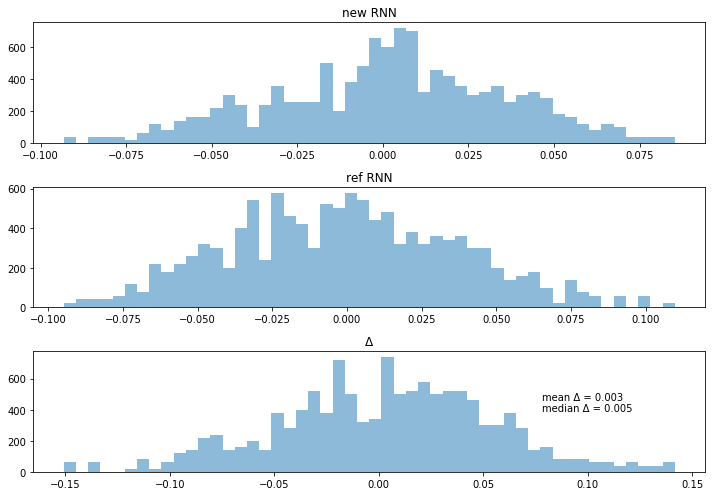

In [410]:
bins = 50

fig, axs = plt.subplots(nrows=3, figsize=(10, 7))
Δ = (out_new.detach().numpy() - out_ref.transpose(1, 0).detach().numpy()).ravel()
axs[0].hist(out_new.detach().numpy().ravel(), bins=bins, label="new", alpha=.5)
axs[0].set_title("new RNN")
axs[1].hist(out_ref.detach().numpy().ravel(), bins=bins, label="ref", alpha=.5)
axs[1].set_title("ref RNN")
axs[2].hist(Δ, bins=bins, label="Δ", alpha=.5)
axs[2].set_title("Δ")
axs[2].text(axs[2].get_xlim()[1]/2, axs[2].get_ylim()[1]/2, f"mean Δ = {Δ.mean():.3f}\nmedian Δ = {np.median(Δ):.3f}")
plt.tight_layout()
plt.show()

Excellent, value distributions of the outputs given the same input look very similar and the median and even the mean of the output differences between the two implementations of the LSTM element are close to 0. This indicates the errors / differences in implementation are not too severe.

In [500]:
class Model(torch.nn.Module):
        
    def __init__(self, num_in: int, num_hidden: int, rec:Recorder(), keep_state: bool=False, rnn_use_bn:bool=False):
        super().__init__()
        self.gru = GRU(num_in=num_in, num_hidden=num_hidden, keep_state=keep_state, use_batchnorm=rnn_use_bn)
        self.h2o = torch.nn.Linear(in_features=num_hidden, out_features=num_in)
        self.rec = rec
        
    def forward(self, x: torch.Tensor):
                
        self.rec.append_parameters(self)
            
        a = self.gru(x)
        self.rec.append_activations("gru", a)
        self.rec.append_activations("hidden_state", self.gru.hidden_state)
        a = self.h2o(a)
        self.rec.append_activations("h2o", a)
        a = torch.sigmoid(a)
        self.rec.append_activations("sigmoid", a)
        return a*255.
    
num_in=img_tensor2d_train.size()[1]
num_hidden=img_tensor2d_train.size()[1]//2

model = Model(num_in=num_in, num_hidden=num_hidden, rec=Recorder(), rnn_use_bn=False)

model(_x)

tensor([[[151.5626, 132.3794,  97.0562,  ..., 147.4087, 157.3988, 129.3689],
         [159.0362, 159.3574,  94.3067,  ..., 150.9269, 169.5707, 106.8687],
         [152.4569, 105.5860,  98.4571,  ..., 172.2442, 165.9817, 101.6572],
         [165.2928, 136.0011, 109.3556,  ..., 158.9090, 155.7948, 111.7808]],

        [[163.9373, 163.3712, 105.8734,  ..., 150.7057, 167.5087, 106.0734],
         [157.3469, 111.1628, 105.7060,  ..., 169.1035, 165.5004,  94.8900],
         [172.3205, 141.4593, 115.3653,  ..., 156.8336, 155.6052, 102.1752],
         [165.4524, 131.7912, 112.9579,  ..., 162.8839, 171.0576,  89.8700]],

        [[157.3615, 113.2027,  95.6148,  ..., 171.8750, 163.9337,  99.2712],
         [171.7332, 140.1005, 105.7724,  ..., 157.4838, 158.2352, 111.3078],
         [165.2287, 127.3508, 105.6533,  ..., 164.2036, 174.9991,  96.5425],
         [167.0280, 136.3758, 111.0503,  ..., 142.9112, 172.4896, 109.5399]],

        ...,

        [[185.7961, 142.2283,  96.1527,  ..., 147.9072, 

In [501]:
n_iters = 100
opt = torch.optim.Adam(params=model.parameters(), lr=.01)

In [502]:
losses = {"train": [], "valid": []}

for i in range(n_iters):
    _x, _y = db.get_data("train")
    _y_pred = model(_x)
    loss = (_y_pred-_y).pow(2).mean()
    losses["train"].append(loss.item())
    loss.backward()
    opt.step()
    
    with torch.no_grad():
        _x, _y = db.get_data("valid")
        _y_pred = model(_x)
        loss = (_y_pred-_y).pow(2).mean()
        losses["valid"].append(loss.item())

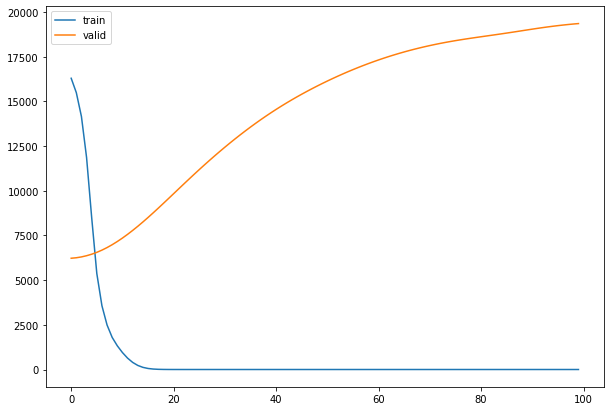

In [503]:
fig, ax = plt.subplots(figsize=(10,7))
for k in sorted(losses):
    ax.plot(np.arange(n_iters), losses[k], label=k)
ax.legend()
plt.show()

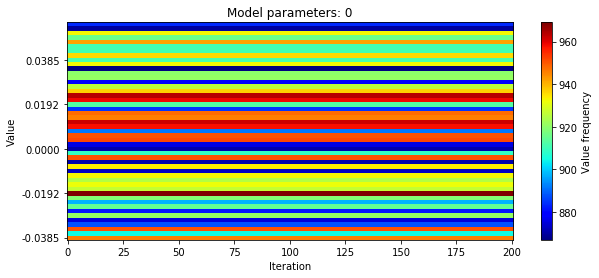

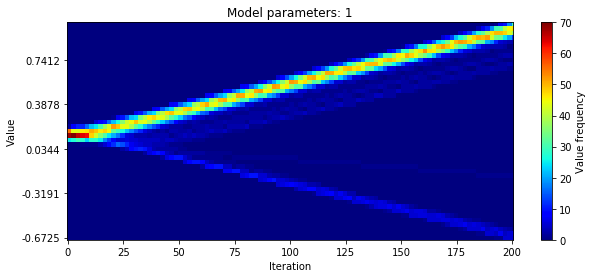

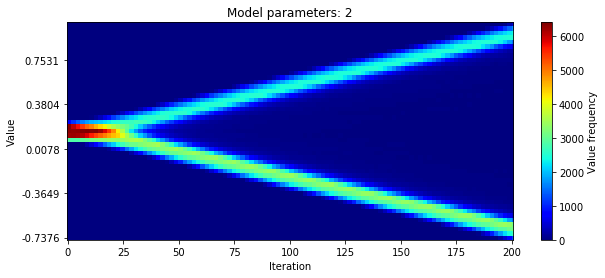

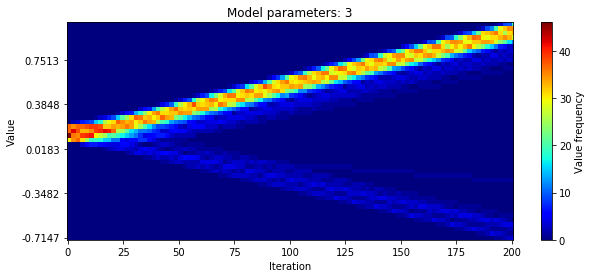

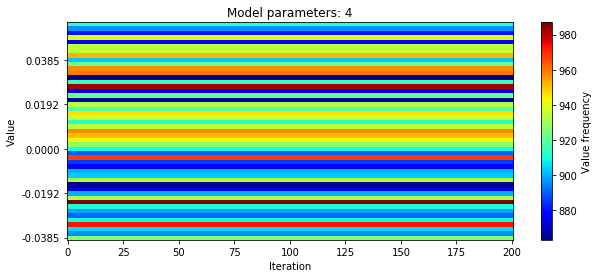

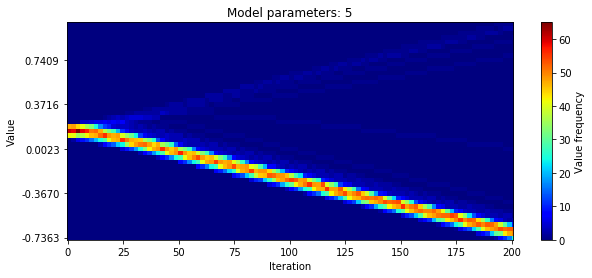

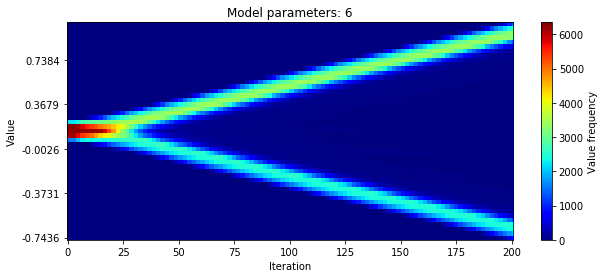

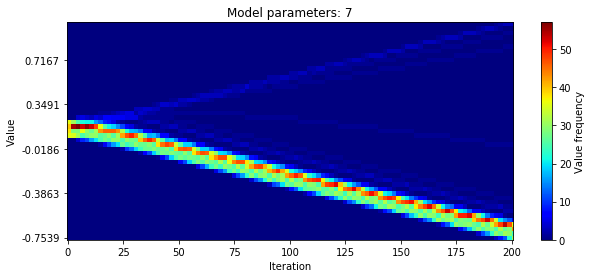

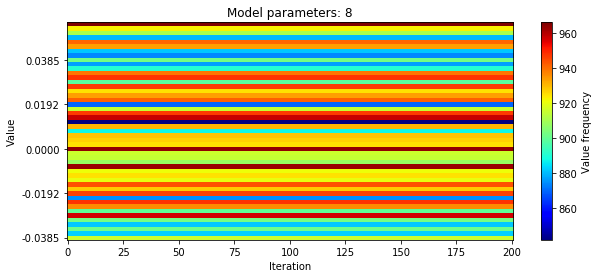

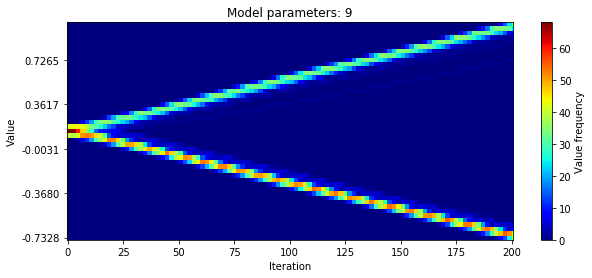

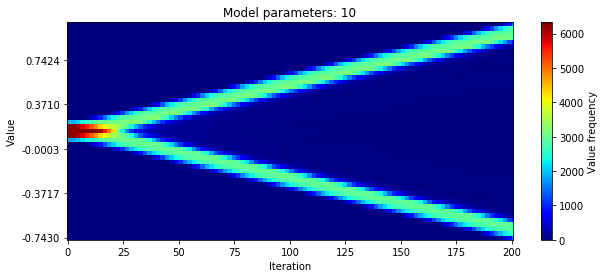

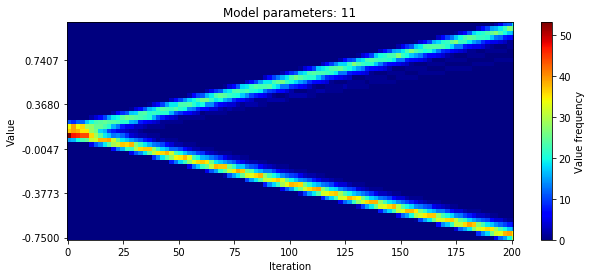

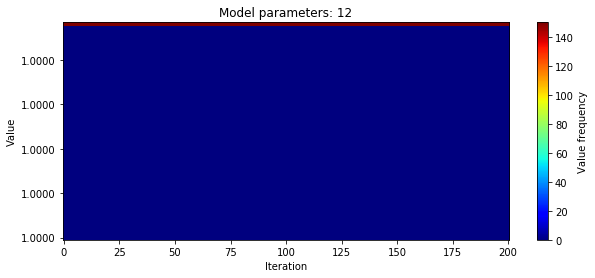

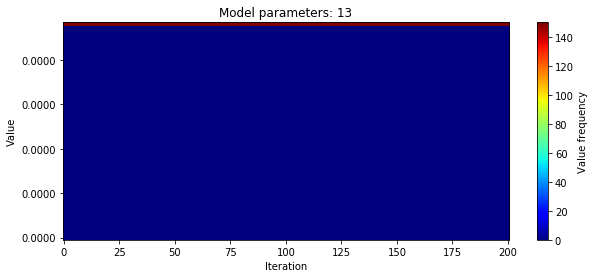

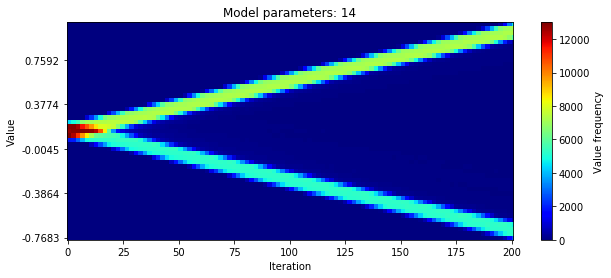

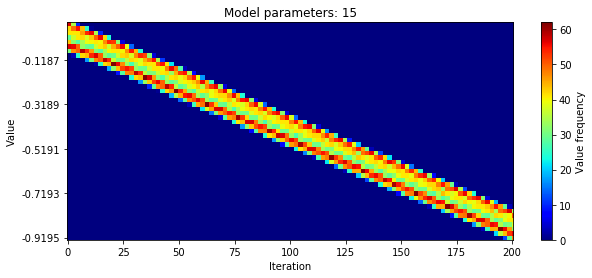

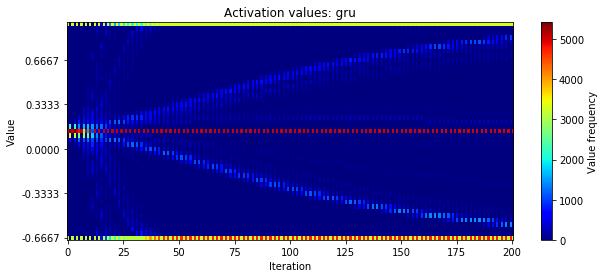

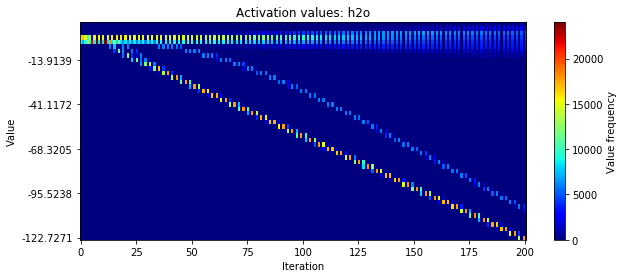

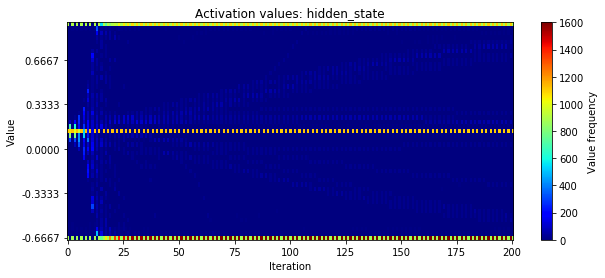

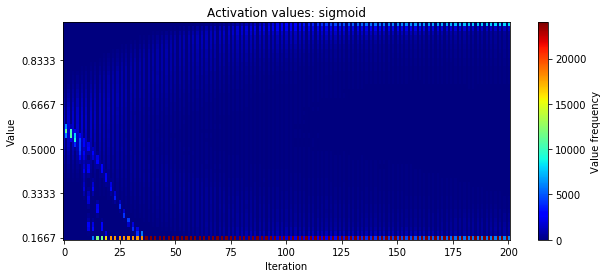

In [504]:
pl = Plotter(model.rec)
pl.plot_parameters()
pl.plot_activations()

Predicting next rows of pixel values

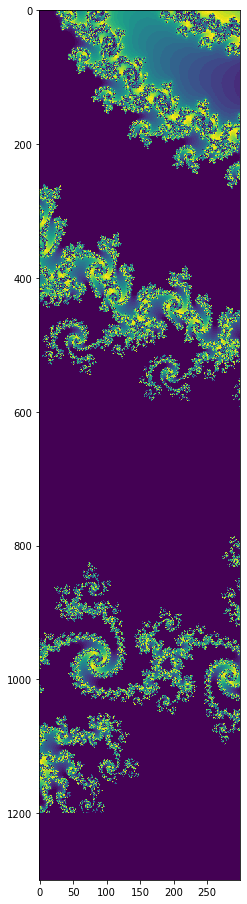

In [415]:
n_pred = 100
img_tensor2d_pred.size()
img_tensor2d_pred = img_tensor2d_valid.clone()

for i in range(n_pred):
    sample = get_sample(img_tensor2d_valid, lag=lag)
    new_row = model(sample)[:,-1,:]
    img_tensor2d_pred = torch.cat((img_tensor2d_pred, new_row), dim=0)
    
img_tensor2d_pred.size()

fig, ax = plt.subplots(figsize=(7,16))
ax.imshow(img_tensor2d_pred.detach().numpy())
plt.show()

## 2. Regularization

General overview: [here](https://www.analyticsvidhya.com/blog/2018/04/fundamentals-deep-learning-regularization-techniques/) → options = adding a penalty for the weights (L1/L2 regularization), averaging over networks (dropout), extending the data set (data augmentation)

### 2.1 Dropout
References:
- [original dropout paper](https://arxiv.org/abs/1207.0580) by Hinton et al.
- pytorch docs on [dropout](https://pytorch.org/docs/stable/nn.html?highlight=dropout#torch.nn.Dropout)

In [416]:
class Dropout(torch.nn.Module):
    
    def __init__(self, p=.5):
        super().__init__()
        self.p = p
        
    def forward(self, x):
        
        if self.training:
            d = torch.bernoulli(1.-torch.ones_like(x)*self.p)
            return x * d / (1.-self.p)
        return x
    
dropout = Dropout(p=.9)
_x_tmp = torch.ones(5, 10)
print("_x_tmp", _x_tmp)
print("dropout(_x_tmp)", dropout(_x_tmp))

_x_tmp tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
dropout(_x_tmp) tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0., 10.,  0.,  0.,  0.,  0., 10.,  0.],
        [ 0.,  0., 10.,  0.,  0.,  0.,  0.,  0., 10.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 10.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])


## 3. Recurrent + dropout

### 3.1 GRU + dropout

In [506]:
class Model(torch.nn.Module):
        
    def __init__(self, num_in: int, num_hidden: int, rec:Recorder, keep_state: bool=False, rnn_use_bn:bool=False,
                 dropout_p=.5):
        super().__init__()
        self.gru = GRU(num_in=num_in, num_hidden=num_hidden, keep_state=keep_state, use_batchnorm=rnn_use_bn)
        self.dropout = Dropout(p=dropout_p)
        self.h2o = torch.nn.Linear(in_features=num_hidden, out_features=num_in)
        self.rec = rec
        
    def forward(self, x: torch.Tensor):
        
        self.rec.append_parameters(self)
            
        a = self.gru(x)
        self.rec.append_activations("gru", a)
        self.rec.append_activations("hidden_state", self.gru.hidden_state)
        a = self.dropout(a)
        self.rec.append_activations("dropout", a)
        a = self.h2o(a)
        self.rec.append_activations("h2o", a)
        a = torch.sigmoid(a)
        self.rec.append_activations("sigmoid", a)
        return a*255.
    
num_in=img_tensor2d_train.size()[1]
num_hidden=img_tensor2d_train.size()[1]//2

model = Model(num_in=num_in, num_hidden=num_hidden, rec=Recorder(), rnn_use_bn=False,
              dropout_p=.8)

model(_x)

tensor([[[130.9843, 199.9930, 114.5257,  ..., 108.7409, 144.6524, 185.3392],
         [105.0498, 157.3706,  50.4235,  ..., 137.4209, 123.9839, 198.5210],
         [167.8559, 183.9495,  67.2106,  ...,  70.9147, 141.2043, 166.0516],
         [ 71.7398,  58.0309,  45.0659,  ..., 105.1359, 112.3629, 150.5021]],

        [[168.8167, 157.6997,  86.8201,  ..., 157.1514, 108.0922, 183.8150],
         [112.5278, 115.8724, 166.1362,  ..., 101.5859, 145.0405,  97.9675],
         [ 81.0003, 207.1680,  91.0884,  ...,  93.7050,  85.9969,  49.5751],
         [120.0689, 136.4079, 185.0243,  ..., 123.4530, 160.7374,  67.1571]],

        [[204.7659, 103.0582, 126.9975,  ..., 153.4517, 106.7246,  97.7707],
         [170.0993, 118.3821, 171.6794,  ..., 191.3310, 105.8319, 138.7926],
         [145.5481, 157.7266, 131.5621,  ..., 202.1317, 122.6701, 102.1659],
         [ 55.8935, 163.4754, 112.2714,  ..., 146.2394, 126.5007,  83.3034]],

        ...,

        [[179.4418,  27.0448, 155.8861,  ..., 185.4035, 

In [507]:
n_iters = 100
opt = torch.optim.Adam(params=model.parameters(), lr=.01)

In [508]:
losses = {"train": [], "valid": []}

for i in range(n_iters):
    _x, _y = db.get_data("train")
    _y_pred = model(_x)
    loss = (_y_pred-_y).pow(2).mean()
    losses["train"].append(loss.item())
    loss.backward()
    opt.step()
    
    with torch.no_grad():
        _x, _y = db.get_data("valid")
        _y_pred = model(_x)
        loss = (_y_pred-_y).pow(2).mean()
        losses["valid"].append(loss.item())

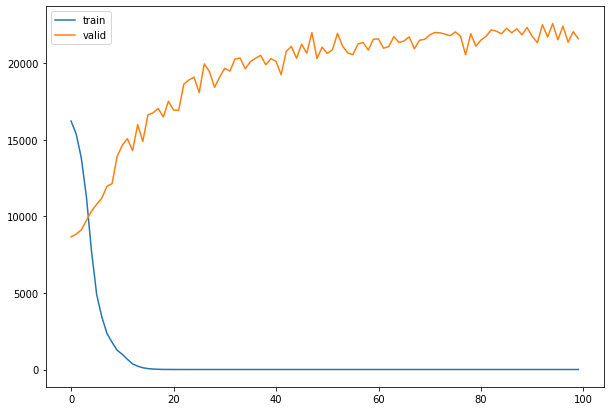

In [509]:
fig, ax = plt.subplots(figsize=(10,7))
for k in sorted(losses):
    ax.plot(np.arange(n_iters), losses[k], label=k)
ax.legend()
plt.show()

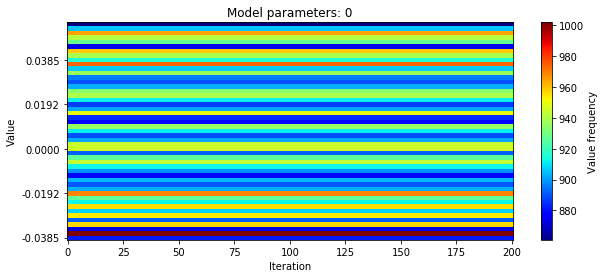

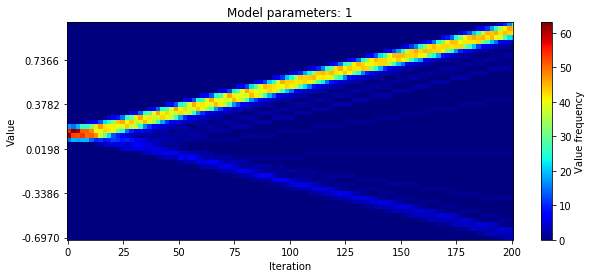

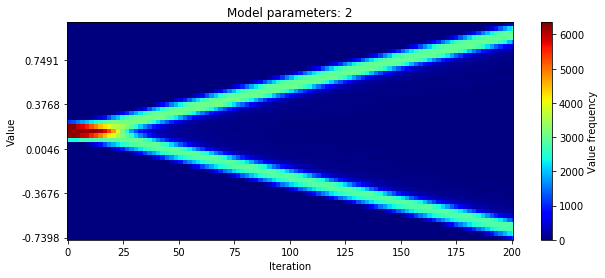

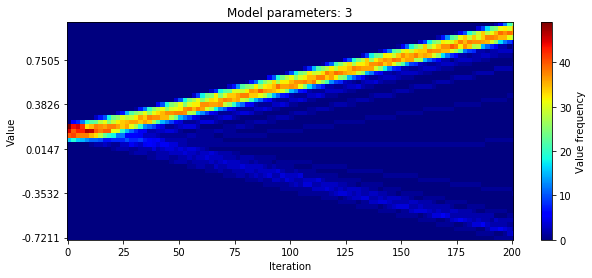

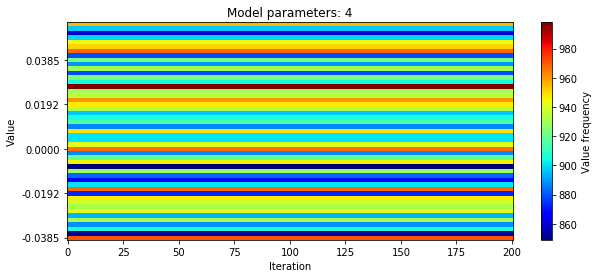

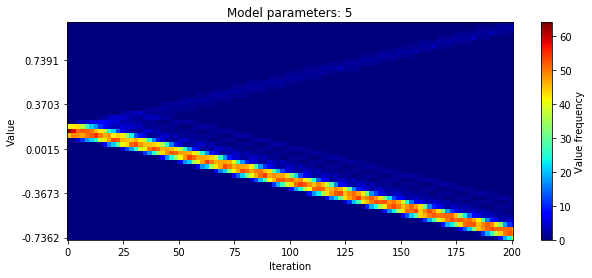

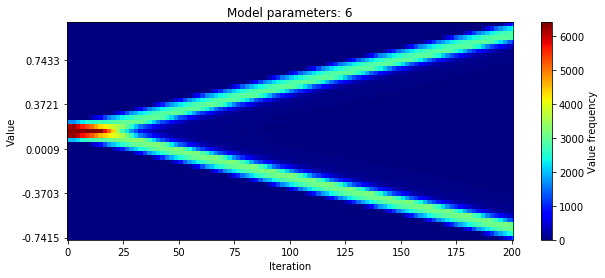

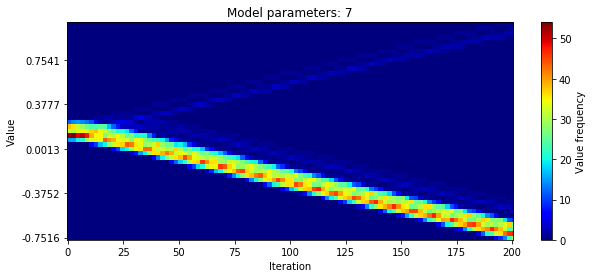

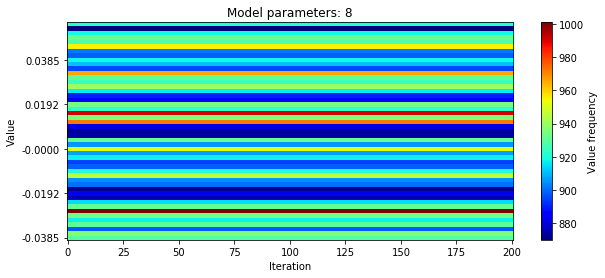

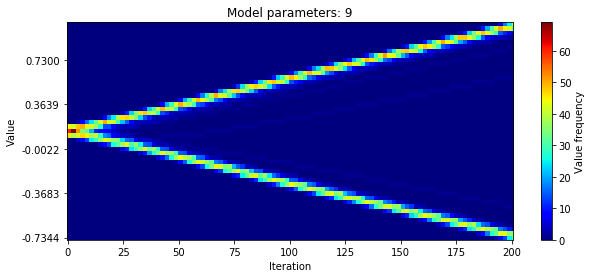

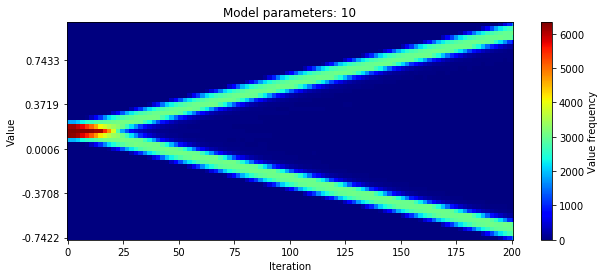

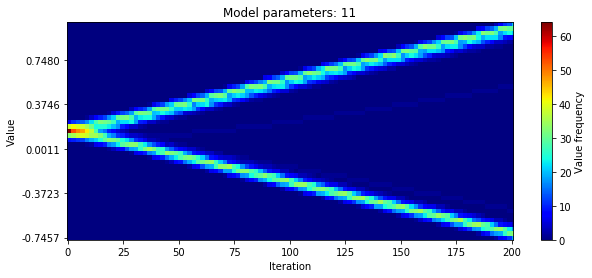

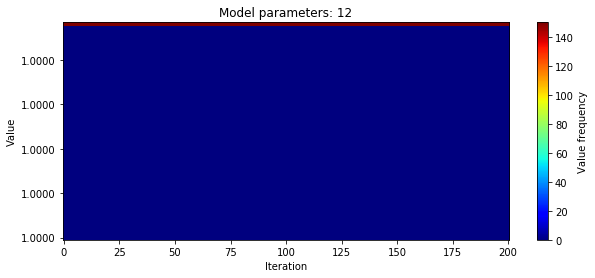

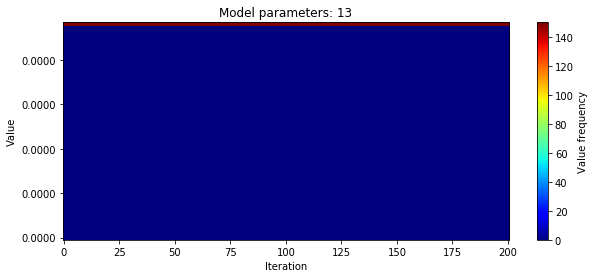

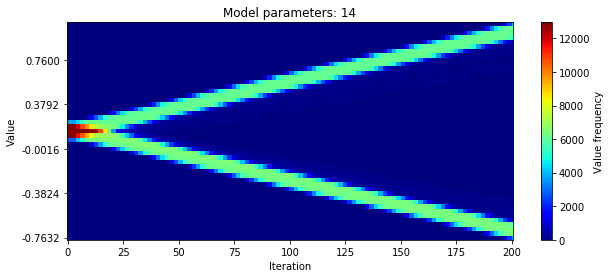

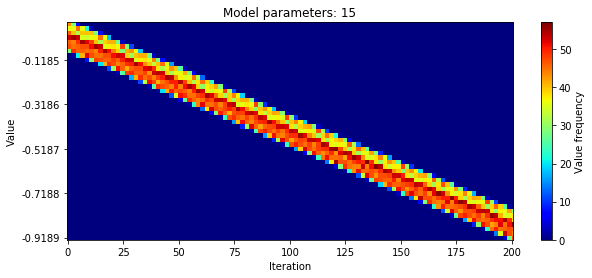

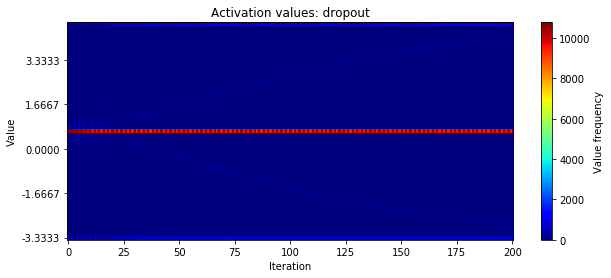

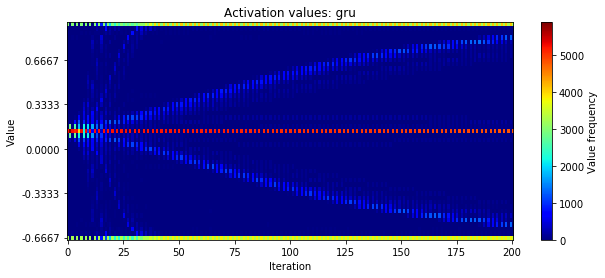

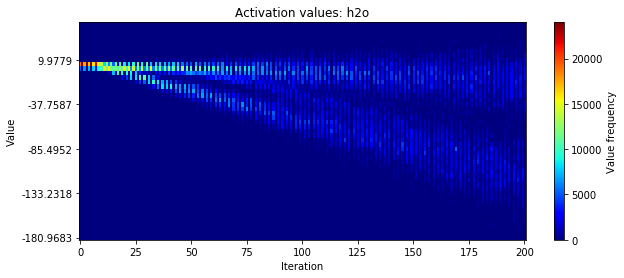

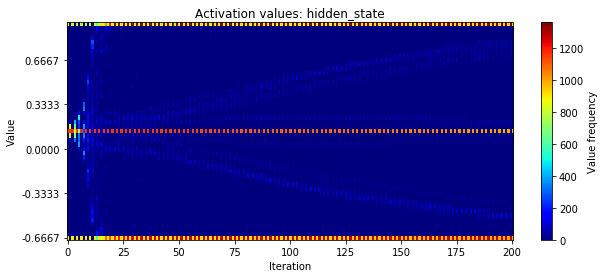

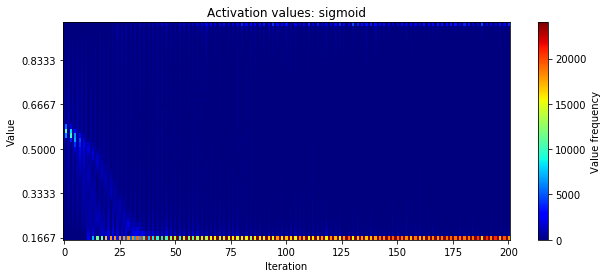

In [510]:
pl = Plotter(model.rec)
pl.plot_parameters()
pl.plot_activations()

Predicting the next rows of pixels

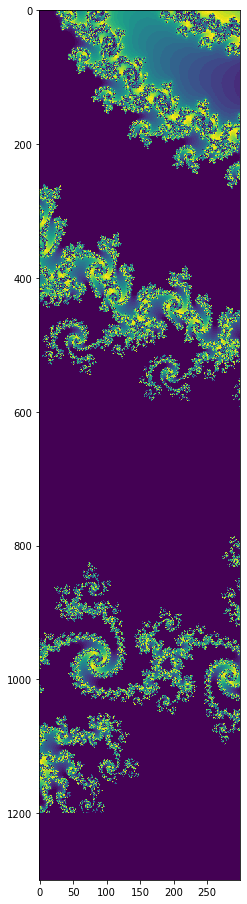

In [428]:
n_pred = 100
model.eval()
img_tensor2d_pred = img_tensor2d_valid.clone()
img_tensor2d_pred.size()

for i in range(n_pred):
    sample = get_sample(img_tensor2d_valid, lag=lag)
    new_row = model(sample)[:,-1,:]
    img_tensor2d_pred = torch.cat((img_tensor2d_pred, new_row), dim=0)
    
img_tensor2d_pred.size()

fig, ax = plt.subplots(figsize=(7,16))
ax.imshow(img_tensor2d_pred.detach().numpy())
plt.show()